# EN 553.614 Term Paper
## Readmission Analysis for Diabete
## Authors: Xingyu Zhu(xzhu76), Yang Ye(yyang), Zhenggang Tan(ztan11)
## 1. Preparation
### 1.1 Load Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf_mat
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy.stats.distributions import chi2
import missingno as mno 
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# sns plot setting
sns.set_context("paper", font_scale=0.8)

### 1.2 Load Dataset

In [3]:
## Load dataset from GitHub
dir = '../Data/diabetic_data.csv'
diabetes = pd.read_csv(dir)

In [4]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

- This dataframe contains a lot of NaNs, but right now the print statement tells the opposite. The reason this happens is instead of NaNs, the dataset uses `?` to represent missing values. We need to change them back to NaN so that `pandas` could recognize them as missing value.

In [5]:
diabetes = diabetes.replace(['?','Unknown/Invalid'],np.nan)
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101763 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

- Now we have our NAs ready.
+ cumulative features for patients
- Since there are multiple records for some patients, instead of deleting duplicate for these patients, we try to calculate cumulative features for them.
1. `time_in_hospital`
2. `number_diagnoses`
3. `num_medications`
4. `num_procedures`
5. `num_lab_procedures`
6. `number_inpatient`
7. `number_emergency`
8. `number_outpatient`

In [6]:
to_extract_features = ['time_in_hospital', 'number_diagnoses', 'num_medications', 'num_procedures', 'num_lab_procedures', 'number_inpatient', 'number_emergency', 'number_outpatient']
diabetes['number_visits'] = diabetes['patient_nbr'].map(diabetes['patient_nbr'].value_counts())

for feature in to_extract_features:
  diabetes[f'cumulative_{feature}'] = diabetes['patient_nbr'].map(diabetes.groupby('patient_nbr').sum()[f'{feature}'])

diabetes = diabetes.drop(to_extract_features,axis=1)

In [7]:
diabetes=diabetes.drop_duplicates(subset=['patient_nbr'])

In [8]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   encounter_id                   71518 non-null  int64 
 1   patient_nbr                    71518 non-null  int64 
 2   race                           69570 non-null  object
 3   gender                         71515 non-null  object
 4   age                            71518 non-null  object
 5   weight                         2853 non-null   object
 6   admission_type_id              71518 non-null  int64 
 7   discharge_disposition_id       71518 non-null  int64 
 8   admission_source_id            71518 non-null  int64 
 9   payer_code                     40475 non-null  object
 10  medical_specialty              37041 non-null  object
 11  diag_1                         71507 non-null  object
 12  diag_2                         71224 non-null  object
 13  

- Now we have 71518 data left. We will proceed to the next step.

In [9]:
diabetes = diabetes.drop(['encounter_id','patient_nbr'],axis=1)

### 1.3 Train test split
- We see that the dataframe contains a total of 69973 rows and 50 columns. We will conduct EDA later to select proper features and deal with NAs. For now, we will split the dataset into training and testing sets so that when doing EDA there would not be any data leakage. We chose the training set to be 95% of the entire dataset and testing set to be 5% of the entire dataset. We chose this combination because since our dataset has ample data, we want to keep as much data as possible for model construction and around 3500 data seem enough for testing purposes.

In [10]:
df_train, df_test = train_test_split(diabetes,train_size=0.95,random_state=42,shuffle=True)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67942 entries, 22686 to 20791
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   race                           66104 non-null  object
 1   gender                         67939 non-null  object
 2   age                            67942 non-null  object
 3   weight                         2692 non-null   object
 4   admission_type_id              67942 non-null  int64 
 5   discharge_disposition_id       67942 non-null  int64 
 6   admission_source_id            67942 non-null  int64 
 7   payer_code                     38477 non-null  object
 8   medical_specialty              35162 non-null  object
 9   diag_1                         67932 non-null  object
 10  diag_2                         67671 non-null  object
 11  diag_3                         66781 non-null  object
 12  max_glu_serum                  67942 non-null  object
 1

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3576 entries, 39874 to 59271
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   race                           3466 non-null   object
 1   gender                         3576 non-null   object
 2   age                            3576 non-null   object
 3   weight                         161 non-null    object
 4   admission_type_id              3576 non-null   int64 
 5   discharge_disposition_id       3576 non-null   int64 
 6   admission_source_id            3576 non-null   int64 
 7   payer_code                     1998 non-null   object
 8   medical_specialty              1879 non-null   object
 9   diag_1                         3575 non-null   object
 10  diag_2                         3553 non-null   object
 11  diag_3                         3512 non-null   object
 12  max_glu_serum                  3576 non-null   object
 13

- Now we can proceed to perform EDA.
## 2. EDA
### 2.0 Goal of Research
- We want to specify our goal of this entire analysis. So, we propose the following research questions:
- Primary: What are the key factors that affect patients' severity/length of readmission to hospital? In other words, can we build a probabilistic model that classifies patients that would be readmitted by hospital?
- Since we have a lot of diabetes-related features in our dataset, would we be able to find a relationship between diabetic patients and severity/length of readmission?
- Another interesting question would be does dosage change and medication change affect diabetic patients' severity/length of readmission?
Thus, we have two tasks with two potential response variables: `time_in_hospital` for regression and `readmitted` for classification.

### 2.1 Some General Information

In [13]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
admission_type_id,67942.0,2.098128,1.505434,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,67942.0,3.585087,5.258171,1.0,1.0,1.0,3.0,28.0
admission_source_id,67942.0,5.656781,4.161814,1.0,1.0,7.0,7.0,25.0
number_visits,67942.0,1.422831,1.093372,1.0,1.0,1.0,1.0,40.0
cumulative_time_in_hospital,67942.0,6.256204,6.564328,1.0,2.0,4.0,8.0,180.0
cumulative_number_diagnoses,67942.0,10.563760,9.125125,1.0,6.0,9.0,9.0,272.0
cumulative_num_medications,67942.0,22.804863,21.935071,1.0,11.0,17.0,27.0,559.0
cumulative_num_procedures,67942.0,1.905199,2.472904,0.0,0.0,1.0,3.0,51.0
cumulative_num_lab_procedures,67942.0,61.317800,53.970143,1.0,36.0,50.0,70.0,1593.0
cumulative_number_inpatient,67942.0,0.904330,4.193271,0.0,0.0,0.0,1.0,382.0


- `number_inpatient` and `number_outpatient` have minimum of 0 which means patients don't have inpatient or outpatient visits in the year preceding the encounter.
- The maximum time for a readmission is 14 days.
### 2.2 Missing Value
- First, we check how many of the variables in our dataset have missing values.

In [14]:
round(df_train.isnull().sum(axis=0)*100/df_train.shape[0],2)

race                              2.71
gender                            0.00
age                               0.00
weight                           96.04
admission_type_id                 0.00
discharge_disposition_id          0.00
admission_source_id               0.00
payer_code                       43.37
medical_specialty                48.25
diag_1                            0.01
diag_2                            0.40
diag_3                            1.71
max_glu_serum                     0.00
A1Cresult                         0.00
metformin                         0.00
repaglinide                       0.00
nateglinide                       0.00
chlorpropamide                    0.00
glimepiride                       0.00
acetohexamide                     0.00
glipizide                         0.00
glyburide                         0.00
tolbutamide                       0.00
pioglitazone                      0.00
rosiglitazone                     0.00
acarbose                 

- We can see that `race`, `weight`, `payer_code`, `medical_specialty`, `diag_1`, `diag_2` and `diag_3`, these 7 features contain `NA`s, of which:
    + `weight` has 96.87% as `NA`
    + `payer_code` has 39.58% as`NA`
    + `medical_specialty` has 49.10% as `NA`
- We will drop these 3 columns since the number of missing values is too large. For the rest, we will impute with mode.

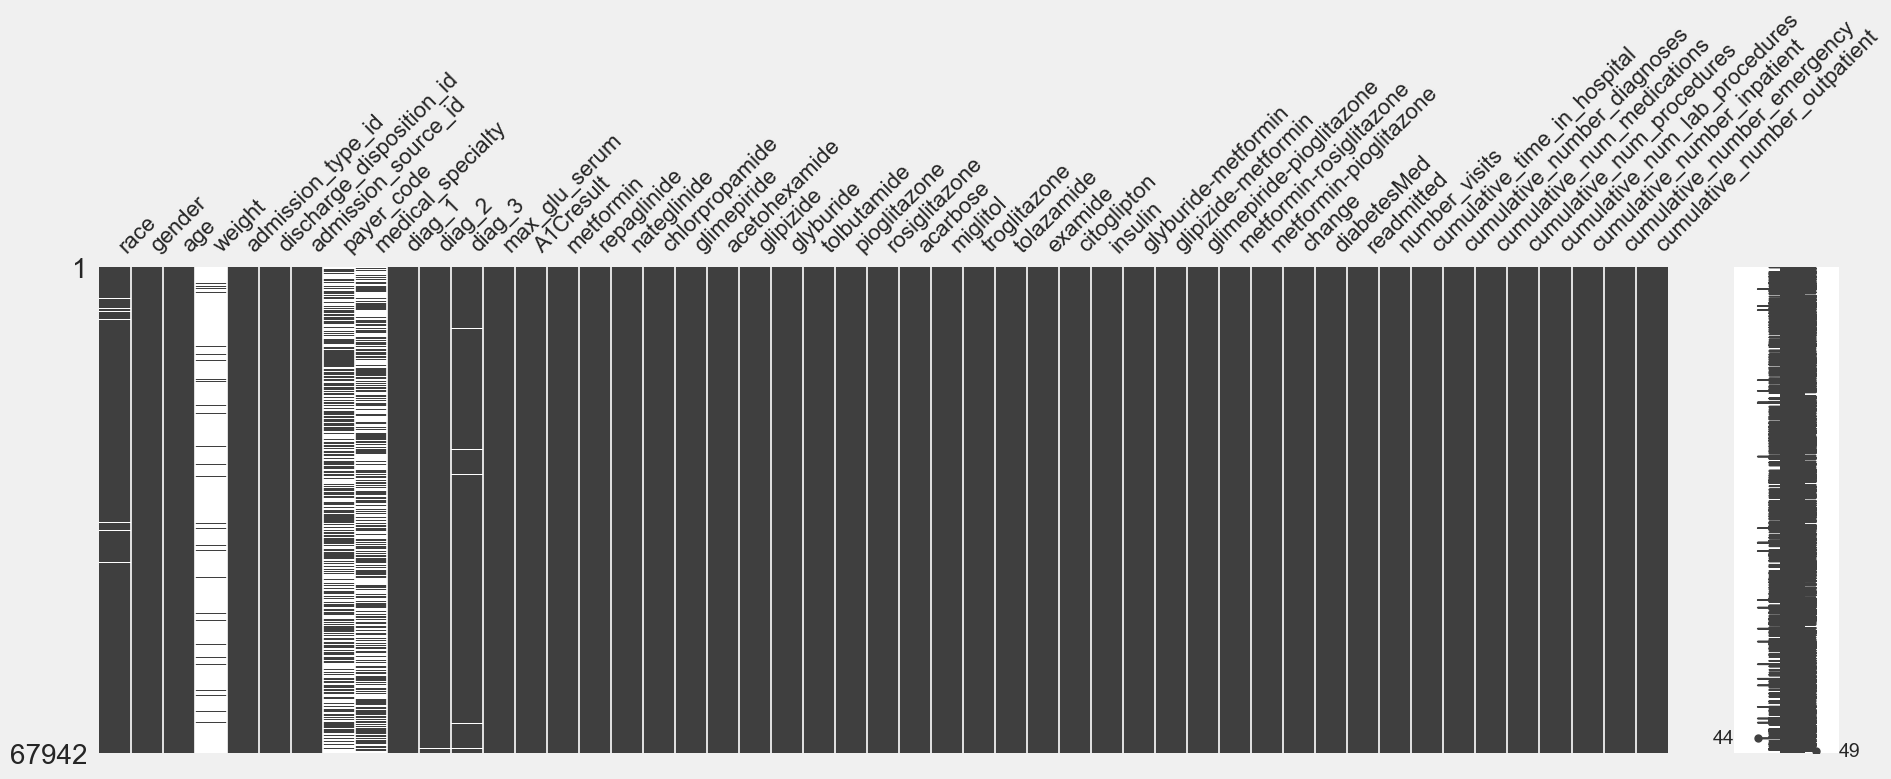

In [15]:
###Visualization of missing values
mno.matrix(df_train, figsize = (20, 6))

###Drop three columns with more than 50% missing value (weight, medical_specialty,payer_code)
df_train = df_train.drop(columns = ['weight','medical_specialty','payer_code'])
df_test = df_test.drop(columns = ['weight','medical_specialty','payer_code'])

<AxesSubplot:>

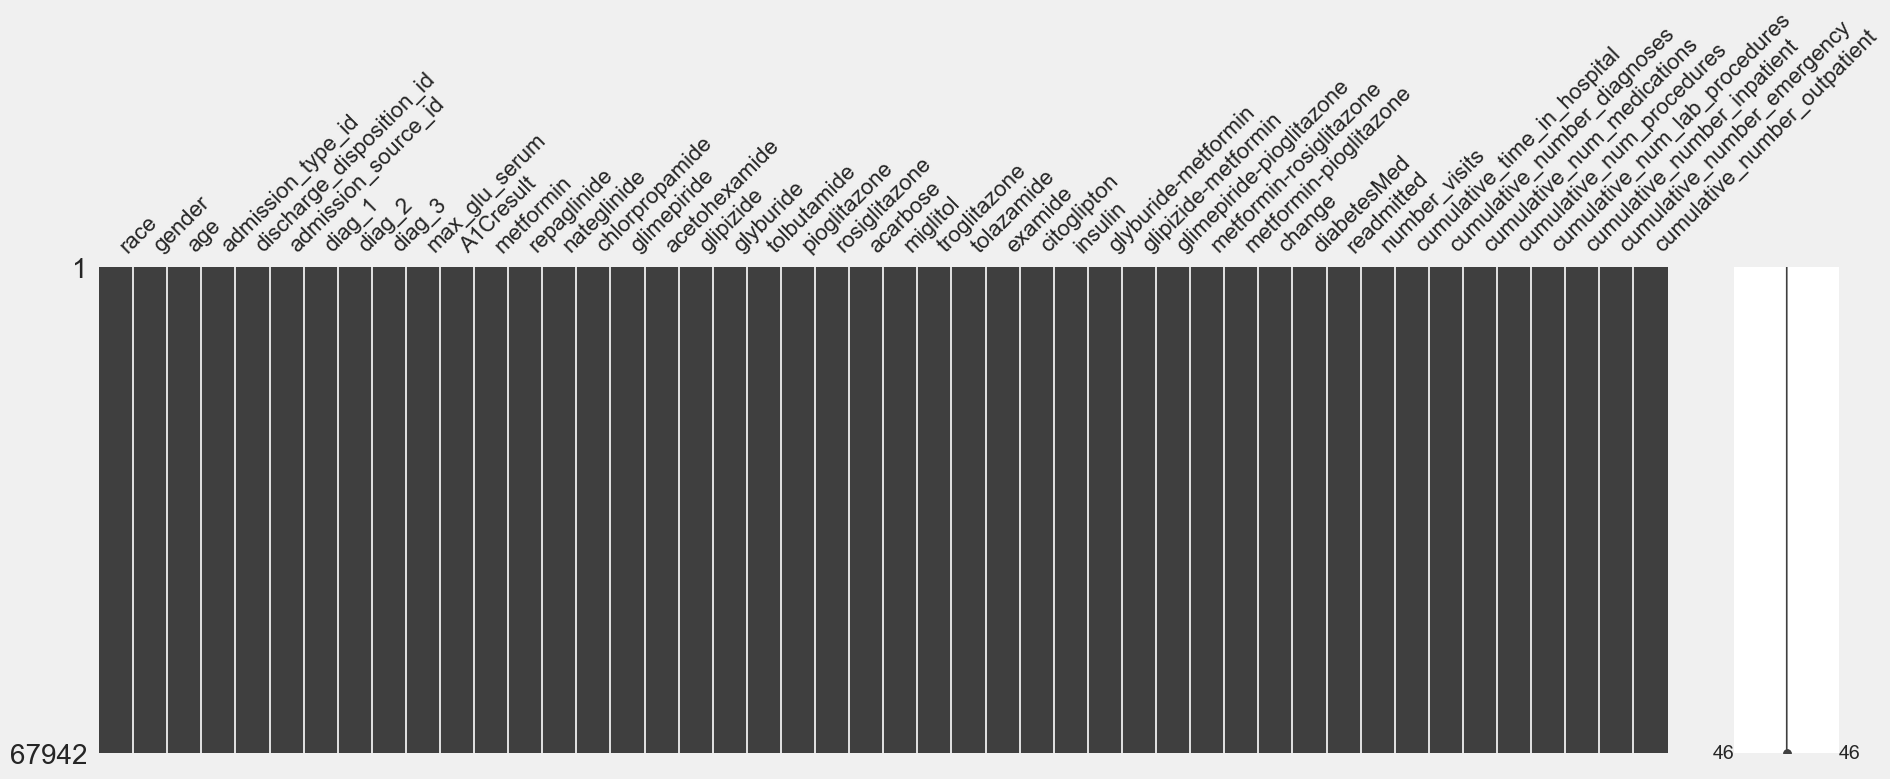

In [16]:
for column in df_train.drop(columns=['readmitted']).columns:
  mode_value = df_train[column].mode()[0]
  df_train[column] = df_train[column].fillna(mode_value)
  df_test[column] = df_test[column].fillna(mode_value)

mno.matrix(df_train, figsize = (20, 6))

- Now all the missing values have been accounted for. We can proceed.
### Feature Inspection
+ `race`

<AxesSubplot:>

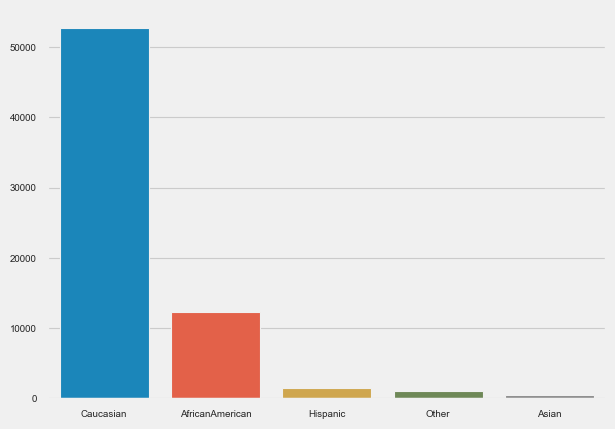

In [17]:
sns.barplot(x=df_train['race'].value_counts().index, y=df_train['race'].value_counts().values)

- We can see that `Caucasian` and `AfricanAmerican` makes up almost all the races, and `Hispanic`, `Other`, `Asian` has really low percentage. So we combine these 3 to be altogether `Other`

<AxesSubplot:>

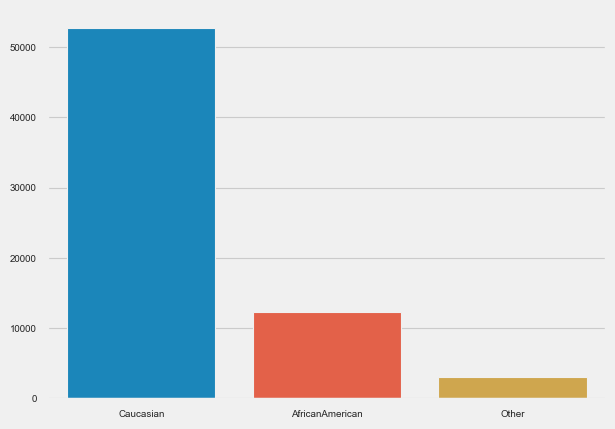

In [18]:
df_train['race'] = df_train['race'].replace({'Asian': 'Other', 'Hispanic': 'Other'}).values
df_test['race'] = df_test['race'].replace({'Asian': 'Other', 'Hispanic': 'Other'}).values
sns.barplot(x=df_train['race'].value_counts().index, y=df_train['race'].value_counts().values)

+`gender`

<AxesSubplot:xlabel='gender', ylabel='count'>

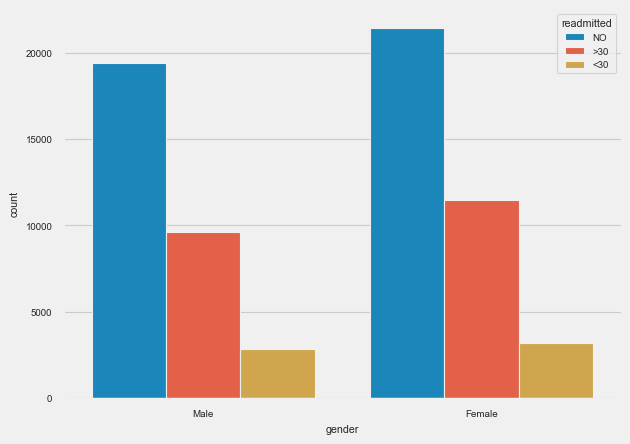

In [19]:
sns.countplot(x=df_train['gender'], hue=df_train['readmitted'])

<AxesSubplot:xlabel='gender', ylabel='count'>

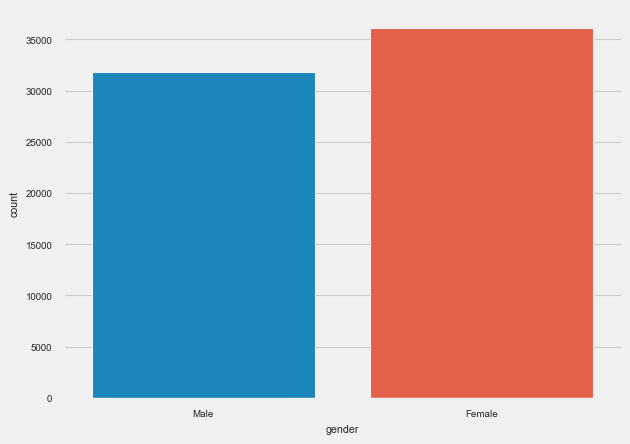

In [20]:
sns.countplot(x=df_train.gender)

- We can see that the distribution of readmission over `gender` is the same for both gender. This feature might not be so useful if we want to discern readmission.
+`Age`
- First, we map all the age ranges to the median of the range for simplicity.

In [21]:
df_train['age'] = df_train['age'].map({ '[70-80)': 75,
                            '[60-70)': 65,
                            '[80-90)': 85,
                            '[50-60)': 55,
                            '[40-50)':45,
                            '[30-40)': 35,
                            '[90-100)':95,
                            '[20-30)':25,
                            '[10-20)':15,
                            '[0-10)': 5})

df_test['age'] = df_test['age'].map({ '[70-80)': 75,
                            '[60-70)': 65,
                            '[80-90)': 85,
                            '[50-60)': 55,
                            '[40-50)':45,
                            '[30-40)': 35,
                            '[90-100)':95,
                            '[20-30)':25,
                            '[10-20)':15,
                            '[0-10)': 5})

<AxesSubplot:xlabel='age', ylabel='count'>

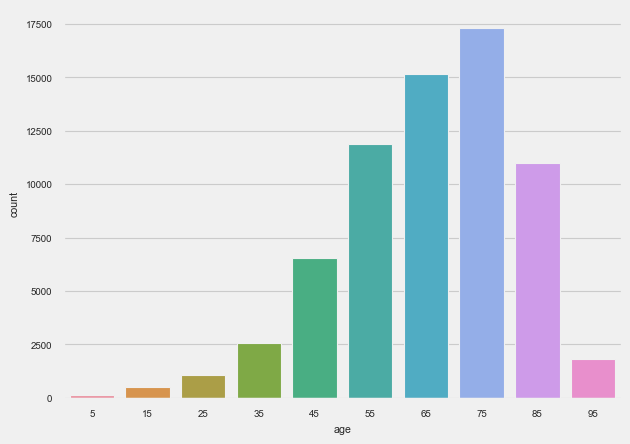

In [22]:
sns.countplot(x=df_train['age'])

<AxesSubplot:xlabel='age', ylabel='count'>

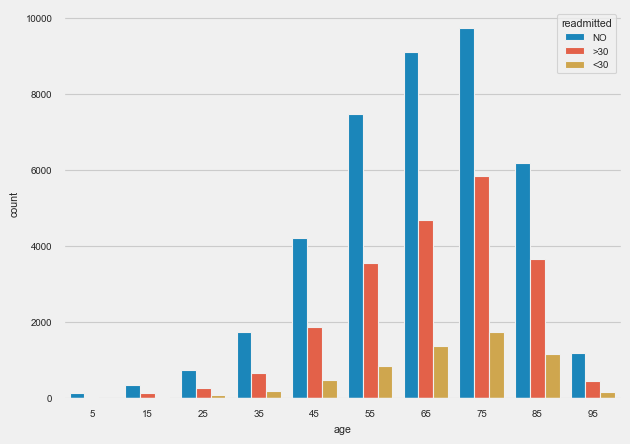

In [23]:
sns.countplot(x=df_train['age'], hue=df_train['readmitted'])

- Although the distribution of `age` is skewed, we can see that the distributions of `readmitted` over `age` seem similar over each of the `age` group. Thus, this variable might not be so useful when building models.
+ `admission_type_id`
- From the id table provided by the dataset, we know that there are 8 categories corresponding to this feature:
  1. Emergency
  2. Urgent
  3. Elective
  4. Newborn
  5. Not Available
  6. NULL
  7. Trauma Center
  8. Not Mapped
- We first map all the names to the ids in the data frame


<AxesSubplot:xlabel='admission_type_id', ylabel='count'>

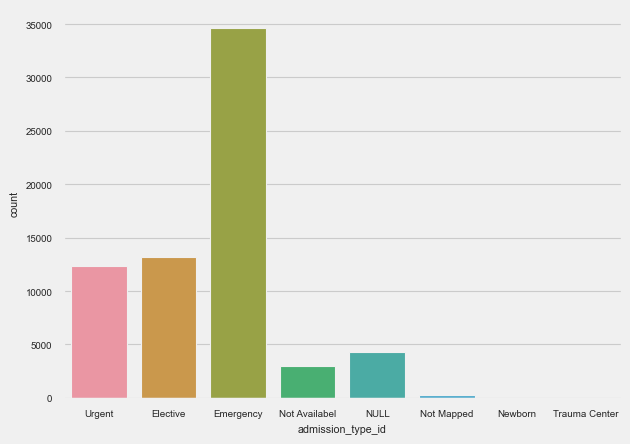

In [24]:
mapping = {1: 'Emergency', 2: 'Urgent', 3: 'Elective', 4: 'Newborn', 5: 'Not Availabel', 6: 'NULL', 7: 'Trauma Center', 8: 'Not Mapped'}
ad_type_list = df_train['admission_type_id'].map(mapping)
sns.countplot(x=ad_type_list)

- We can see that:
    1. `Emergency`, `Urgent` and `Trauma Center` they are actually the same thing! We will put them all under `Emergency`.
    2. `Not Availabel`, `NULL` and `Not Mapped` are also the same category. We will put them under `Unknown`.
    3. `Newborn` have very few data and for simplicity, we will also put it under the category of `Unknown`
- Now we map them to the 3 categories.

<AxesSubplot:xlabel='admission_type_id', ylabel='count'>

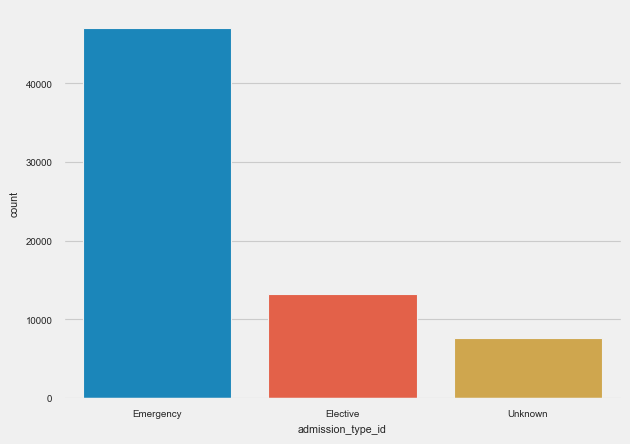

In [25]:
mapping = {1: 'Emergency', 2: 'Emergency', 3: 'Elective', 4: 'Unknown', 5: 'Unknown', 6: 'Unknown', 7: 'Emergency', 8: 'Unknown'}
df_train['admission_type_id'] = df_train['admission_type_id'].map(mapping)
df_test['admission_type_id'] = df_test['admission_type_id'].map(mapping)
sns.countplot(x=df_train['admission_type_id'])

<AxesSubplot:xlabel='admission_type_id', ylabel='count'>

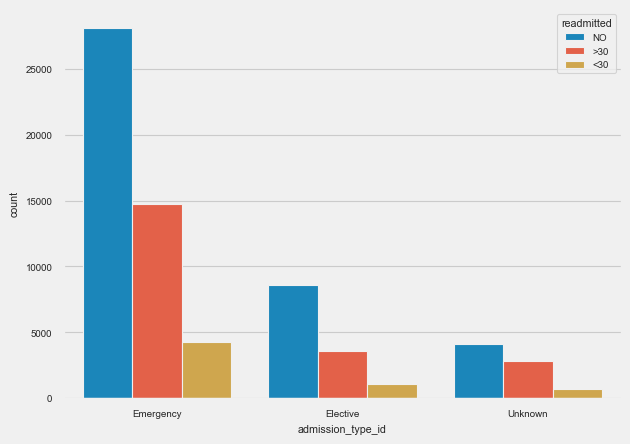

In [26]:
sns.countplot(x=df_train['admission_type_id'],hue=df_train['readmitted'])

- We can see that there are a few differences among each of the `admission_type_id` over `readmitted`.
+ `discharge_disposition_id`
- From the documentation, we know that the `discharge_disposition_id` has 30 categories:
    1. Discharged to home
    2. Discharged/transferred to another short term hospital
    3. Discharged/transferred to SNF
    4. Discharged/transferred to ICF
    5. Discharged/transferred to another type of inpatient care institution
    6. Discharged/transferred to home with home health service
    7. Left AMA
    8. Discharged/transferred to home under the care of Home IV provider
    9. Admitted as an inpatient to this hospital
    10. Neonate discharged to another hospital for neonatal aftercare
    11. Expired
    12. Still patient or expected to return for outpatient services
    13. Hospice / home
    14. Hospice / medical facility
    15. Discharged/transferred within this institution to Medicare approved swing bed
    16. Discharged/transferred/referred another institution for outpatient services
    17. Discharged/transferred/referred to this institution for outpatient services
    18. NULL
    19. Expired at home. Medicaid only, hospice.
    20. Expired in a medical facility. Medicaid only, hospice.
    21. Expired, place unknown. Medicaid only, hospice.
    22. Discharged/transferred to another rehab facility including rehab units of a hospital.
    23. Discharged/transferred to a long term care hospital.
    24. Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
    25. Not Mapped
    26. Unknown/Invalid
    27. Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
    28. Discharged/transferred to a federal health care facility.
    29. Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
    30. Discharged/transferred to a Critical Access Hospital (CAH).
- These are just too many categories to throw into ML models. However, it is possible that we define some larger categories to summarize a little bit. We give the follow categories:
    1. Self-Care
    2. Home Care
    3. Hospice
    4. Expired
    5. Hospital-Care
    6. Unknown
    7. Other

<AxesSubplot:xlabel='discharge_disposition_id', ylabel='count'>

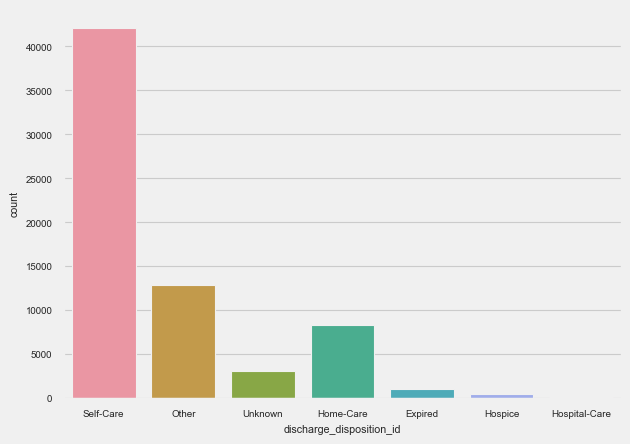

In [27]:
mapping = {'Self-Care': [1, 10],
           'Home-Care': [6, 7, 8],
           'Hospice': [13, 14],
           'Expired': [11, 19, 20, 21],
           'Hospital-Care': [9, 15, 17, 12],
           'Unknown': [18, 25, 26],
           'Other': [2, 3, 4, 5, 10, 16, 22, 23, 24, 27, 28, 29, 30]}
for category, ids in mapping.items():
    df_train['discharge_disposition_id']=df_train['discharge_disposition_id'].replace(ids, category)
    df_test['discharge_disposition_id']=df_test['discharge_disposition_id'].replace(ids, category)
sns.countplot(x=df_train['discharge_disposition_id'])

<AxesSubplot:xlabel='discharge_disposition_id', ylabel='count'>

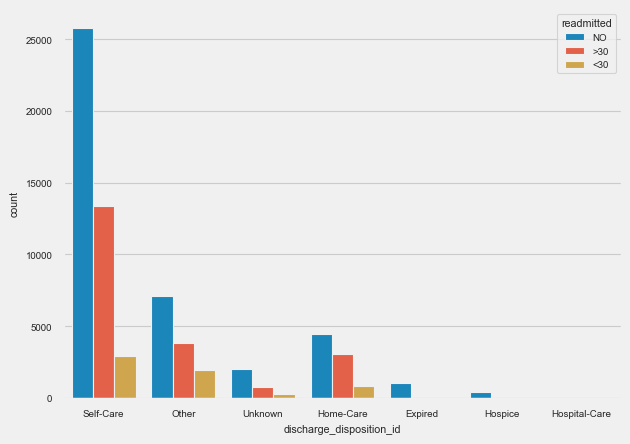

In [28]:
sns.countplot(x=df_train['discharge_disposition_id'],hue=df_train['readmitted'])

- We can see that there is some kind of relationship between the grouped `discharge_dispostion_id` and `readmitted`.
- Note that since we include `Expired`, this group of patients should not have been `readmitted`, given its meaning. We can check that by:

In [29]:
df_train[df_train['discharge_disposition_id'] == 'Expired' ][['discharge_disposition_id', 'readmitted']].value_counts()

discharge_disposition_id  readmitted
Expired                   NO            1020
dtype: int64

+ `admission_source_id`
- From the documentation, we know that the `admission_source_id` has 25 categories:
1. Physician Referral
2. Clinic Referral
3. HMO Referral
4. Transfer from a hospital
5. Transfer from a Skilled Nursing Facility (SNF)
6. Transfer from another health care facility
7. Emergency Room
8. Court/Law Enforcement
9. Not Available
10. Transfer from critial access hospital
11. Normal Delivery
12. Premature Delivery
13. Sick Baby
14. Extramural Birth
15. Not Available
16. NULL
17. Transfer From Another Home Health Agency
18. Readmission to Same Home Health Agency
19. Not Mapped
20. Unknown/Invalid
21. Transfer from hospital inpt/same fac reslt in a sep claim
22. Born inside this hospital
23. Born outside this hospital
24. Transfer from Ambulatory Surgery Center
25. Transfer from Hospice
- As before, these are too many categories, so we will make a grouped `admission_source_id`:

<AxesSubplot:xlabel='admission_source_id', ylabel='count'>

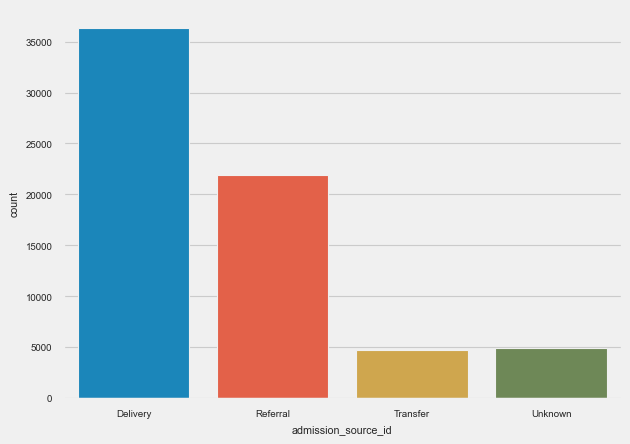

In [30]:
mapping = {'Referral': [1, 2, 3, ],
           'Transfer': [4, 5, 6, 10, 18, 22, 25, 26],
           'Readmission':[19],
           'Delivery': [7, 8, 11, 12],
           'Unknown': [9, 15, 17, 20, 21, 13, 14, 23, 24]}
for category, ids in mapping.items():
    df_train['admission_source_id']=df_train['admission_source_id'].replace(ids, category)
    df_test['admission_source_id']=df_test['admission_source_id'].replace(ids, category)
sns.countplot(x=df_train['admission_source_id'])

<AxesSubplot:xlabel='admission_source_id', ylabel='count'>

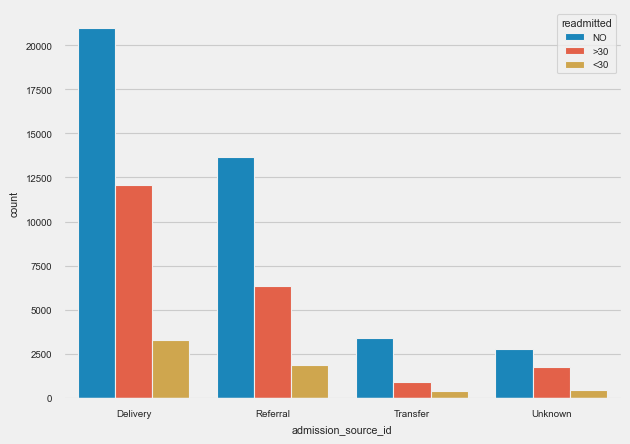

In [31]:
sns.countplot(x=df_train['admission_source_id'],hue=df_train['readmitted'])

- `admission_source_id` does not seem to be a very good feature for classification of `readmitted`.
+ `cumulative_time_in_hospital`
- `cumulative_time_in_hospital` is one of the few numerical variable, and is also one of our potential response variables for regression.

(0.0, 30.0)

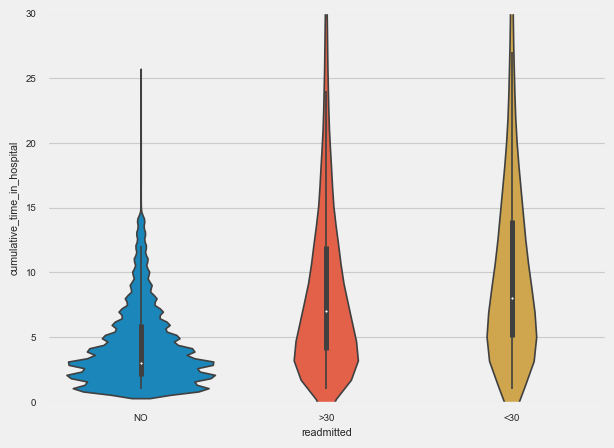

In [32]:
plot = sns.violinplot(data=df_train,y='cumulative_time_in_hospital',x='readmitted',kind='kde')
plt.ylim([0,30])

- We can see that the shorter the time to readmission, the more likely a patient to be in hospital for a long time.
+ `cumulative_num_lab_procedures`
- `cumulative_num_lab_procedures` is also a continuous variable.

(0.0, 300.0)

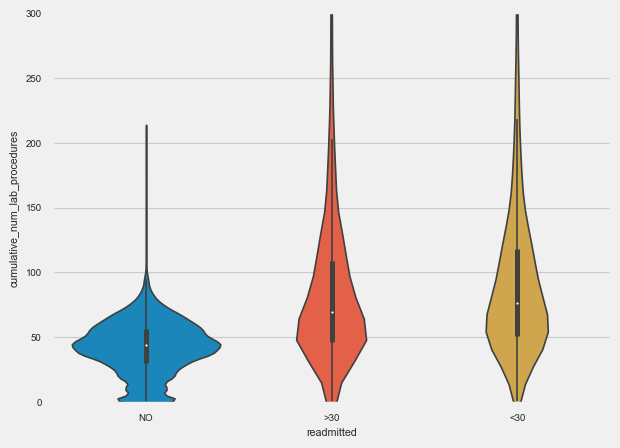

In [33]:
plot = sns.violinplot(data=df_train,y='cumulative_num_lab_procedures',x='readmitted',kind='kde')
plt.ylim([0,300])

+ `cumulative_num_procedures`
- `cumulative_num_procedures` we also take it as a continuous variable:

(0.0, 10.0)

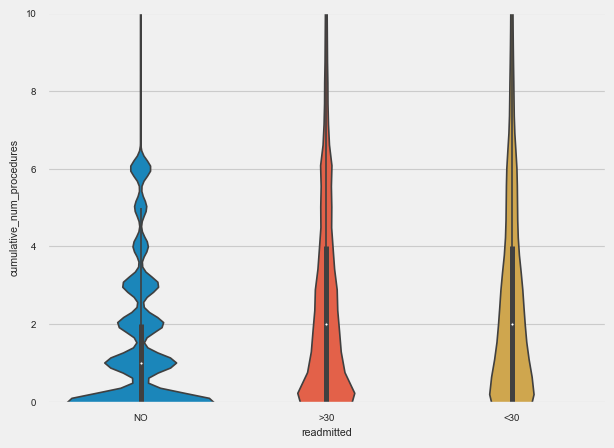

In [34]:
plot = sns.violinplot(data=df_train,y='cumulative_num_procedures',x='readmitted',kind='kde')
plt.ylim([0,10])

+ `cumulative_num_medications`
- We also take `cumulative_num_medications` as a continuous feature.

(0.0, 100.0)

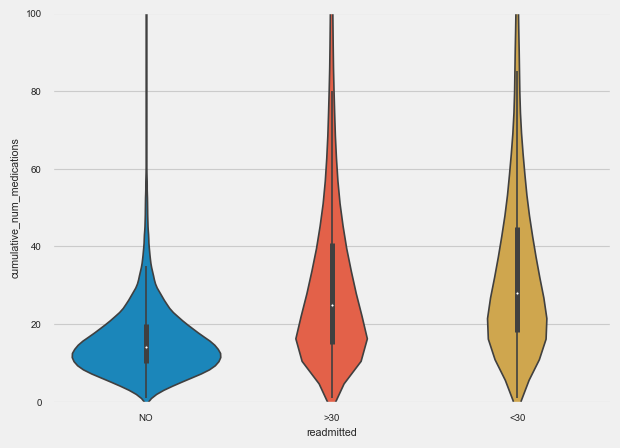

In [35]:
plot = sns.violinplot(data=df_train,y='cumulative_num_medications',x='readmitted',kind='kde')
plt.ylim([0,100])

+ `cumulative_number_outpatient`, `cumulative_number_inpatient` & `cumulative_number_emergency`

(0.0, 5.0)

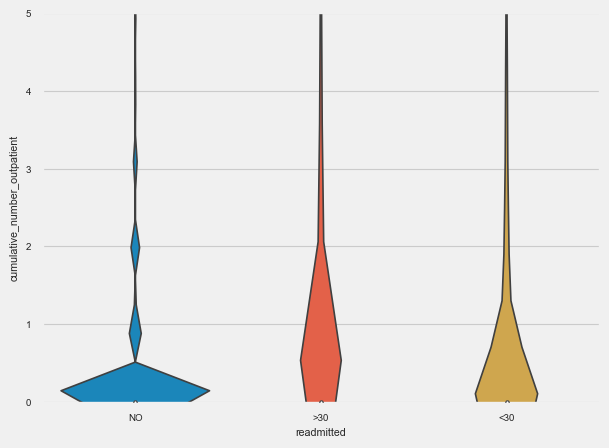

In [36]:
plot = sns.violinplot(data=df_train,y='cumulative_number_outpatient',x='readmitted',kind='kde')
plt.ylim([0,5])

(0.0, 5.0)

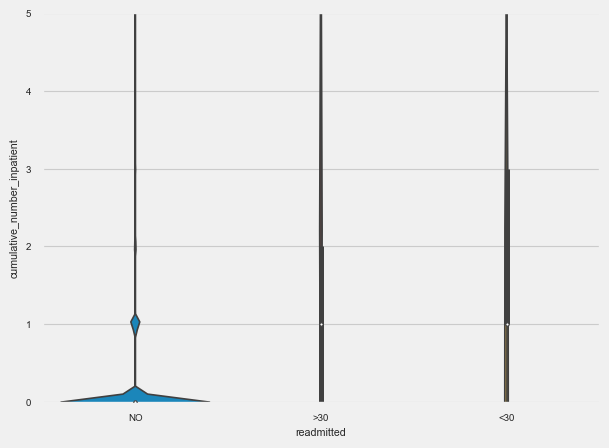

In [37]:
plot = sns.violinplot(data=df_train,y='cumulative_number_inpatient',x='readmitted',kind='kde')
plt.ylim([0,5])

(0.0, 5.0)

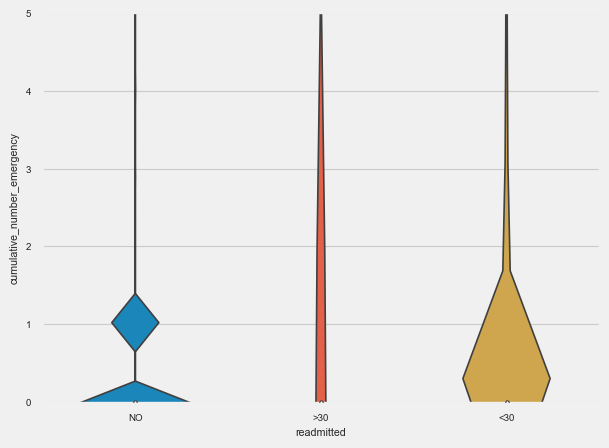

In [38]:
plot = sns.violinplot(data=df_train,y='cumulative_number_emergency',x='readmitted',kind='kde')
plt.ylim([0,5])

- We can see that most patients do not have neither outpatient nor inpatient visit to the hospital. The same goes with `number_emergency`. We think that it may be better if we could construct a new variable called `visit_to_hospital` by combining the 3 variables.

In [39]:
df_train['cumulative_visit_to_hospital'] = df_train['cumulative_number_outpatient'] + df_train['cumulative_number_emergency'] + df_train['cumulative_number_inpatient']
df_train = df_train.drop(['cumulative_number_outpatient','cumulative_number_emergency','cumulative_number_inpatient'],axis=1)
df_test['cumulative_visit_to_hospital'] = df_test['cumulative_number_outpatient'] + df_test['cumulative_number_emergency'] + df_test['cumulative_number_inpatient']
df_test = df_test.drop(['cumulative_number_outpatient','cumulative_number_emergency','cumulative_number_inpatient'],axis=1)

(0.0, 10.0)

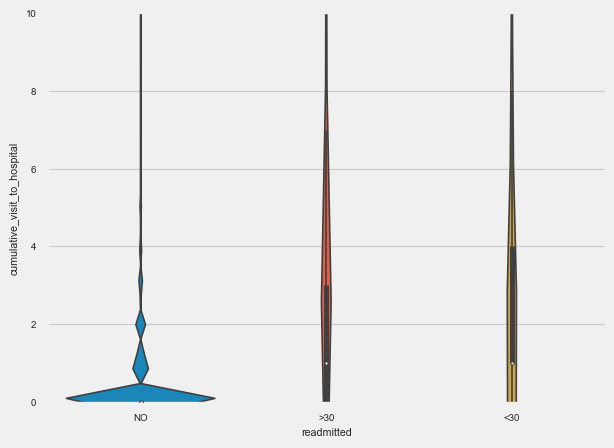

In [40]:
plot = sns.violinplot(data=df_train,y='cumulative_visit_to_hospital',x='readmitted',kind='kde')
plt.ylim([0,10])

+ `diag_1` & `diag_2` & `diag_3`
- These three variables stand for the 1st, 2nd, and 3rd diagnosis doctor makes about a patient.
- `Diagnosis 1`, `Diagnosis 2`, `Diagnosis 3` have 848, 923, and 954 unique values in each feature. At first, we thought that we would have no other option but to delete these features from our analysis. However, after examining the documentation of the dataset, we found that the diagnoses are recorded according to the International Classification of Disease 9th Revision(ICD9), for which we could group the categories as follows:
- `circulatory` for icd9: 390–459, 785
- `digestive` for icd9: 520–579, 787
- `genitourinary` for icd9: 580–629, 788
- `diabetes` for icd9: 250.xx
- `injury` for icd9: 800–999
- `musculoskeletal` for icd9: 710–739
- `neoplasms` for icd9: 140–239
- `respiratory` for icd9: 460–519, 786
- `other` for otherwise

In [41]:
def transform_diagnosis(diag):
    """
    Transforms diagnosis from ICD9 notation to 9 categories.
    """
    try:
        diag = float(diag)
    except ValueError:
        value = 'other'
        return value

    if (390<=diag<=459) or diag==785:
        value = 'circulatory'
    elif (520<=diag<=579) or diag==787:
        value = 'digestive'
    elif (580<=diag<=629) or diag==788:
        value = 'genitourinary'
    elif 250.0<=diag<251.00:
        value = 'diabete'
    elif 800<=diag<=999:
        value = 'injury'
    elif 710<=diag<=739:
        value = 'musculoskeletal'
    elif 140<=diag<=239:
        value = 'neoplasms'
    elif (460<=diag<=519) or diag==786:
        value = 'respiratory'
    else:
        value = 'other'
    return value

In [42]:
df_train['diag_1'] = df_train.apply(lambda x: transform_diagnosis(x['diag_1']), axis=1)
df_train['diag_2'] = df_train.apply(lambda x: transform_diagnosis(x['diag_2']), axis=1)
df_train['diag_3'] = df_train.apply(lambda x: transform_diagnosis(x['diag_3']), axis=1)
df_test['diag_1'] = df_test.apply(lambda x: transform_diagnosis(x['diag_1']), axis=1)
df_test['diag_2'] = df_test.apply(lambda x: transform_diagnosis(x['diag_2']), axis=1)
df_test['diag_3'] = df_test.apply(lambda x: transform_diagnosis(x['diag_3']), axis=1)

[Text(0.5, 1.0, 'Diagnosis 1')]

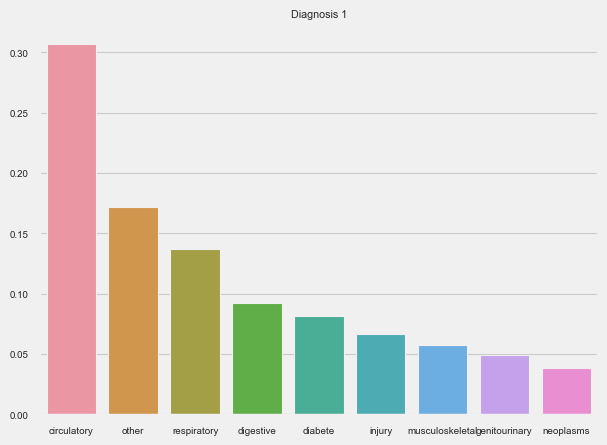

In [43]:
sns.barplot(df_train.diag_1.value_counts(normalize=True).index,df_train.diag_1.value_counts(normalize=True).values).set(title='Diagnosis 1')

[Text(0.5, 1.0, 'Diagnosis 2')]

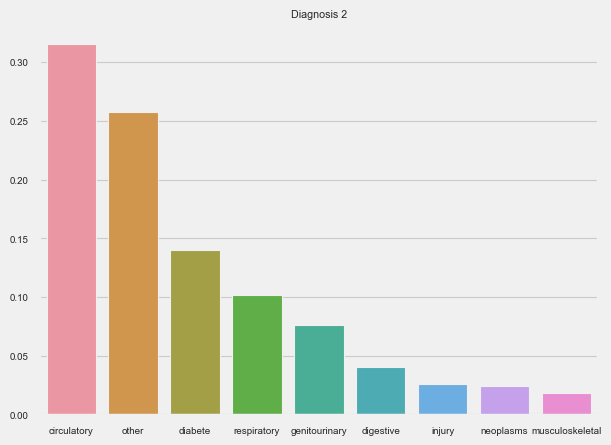

In [44]:
sns.barplot(df_train.diag_2.value_counts(normalize=True).index,df_train.diag_2.value_counts(normalize=True).values).set(title='Diagnosis 2')

[Text(0.5, 1.0, 'Diagnosis 3')]

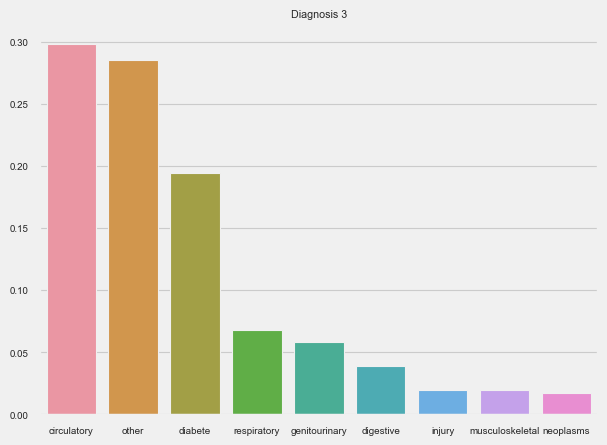

In [45]:
sns.barplot(df_train.diag_3.value_counts(normalize=True).index,df_train.diag_3.value_counts(normalize=True).values).set(title='Diagnosis 3')

- Bravo! We can see that after transformation, each of the diagnoses now has 9 categories. As of now, we should be able to include these 3 variables in our model construction.
+ `cumulative_number_diagnoses`
- This is also a continuous variable.

(0.0, 30.0)

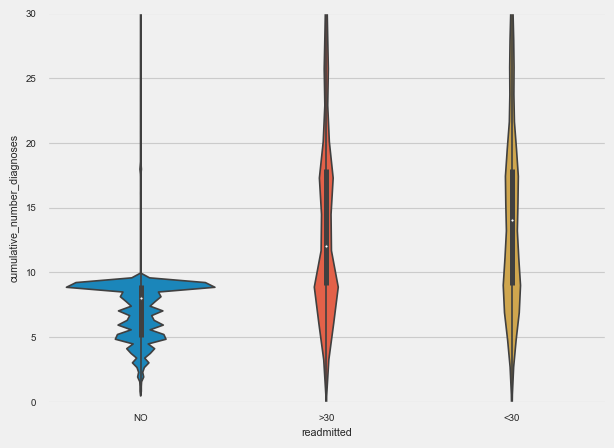

In [46]:
plot = sns.violinplot(data=df_train,y='cumulative_number_diagnoses',x='readmitted',kind='kde')
plt.ylim([0,30])

+ `max_glu_serum`

<AxesSubplot:xlabel='max_glu_serum', ylabel='count'>

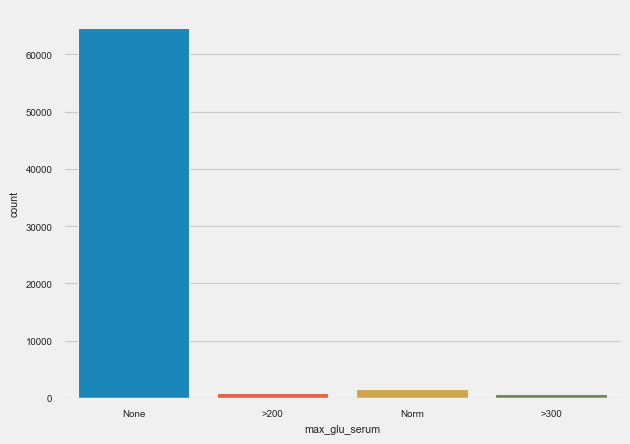

In [47]:
sns.countplot(x=df_train['max_glu_serum'])

<AxesSubplot:xlabel='max_glu_serum', ylabel='count'>

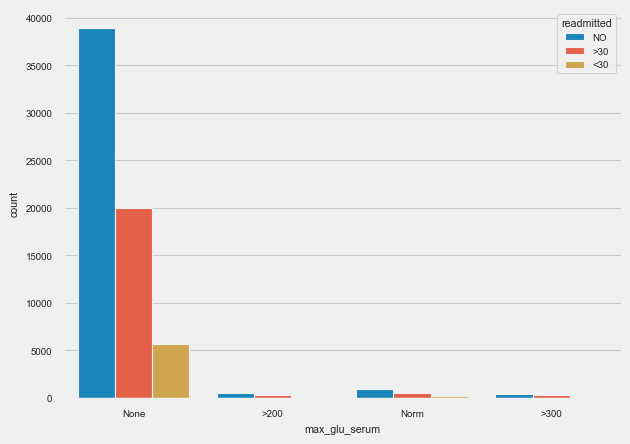

In [48]:
sns.countplot(x=df_train.max_glu_serum,hue=df_train.readmitted)

+ `A1Cresult`

<AxesSubplot:xlabel='A1Cresult', ylabel='count'>

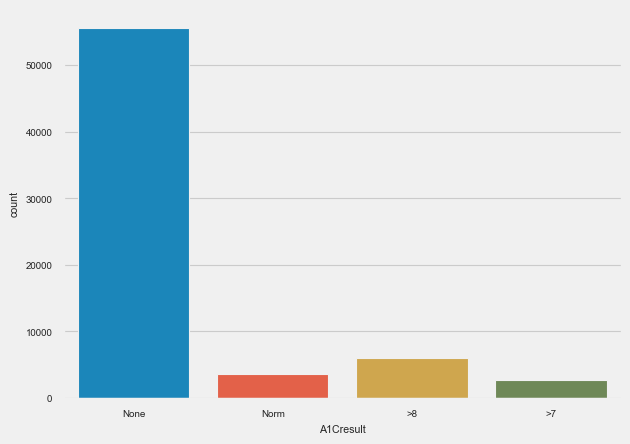

In [49]:
sns.countplot(x=df_train['A1Cresult'])

<AxesSubplot:xlabel='A1Cresult', ylabel='count'>

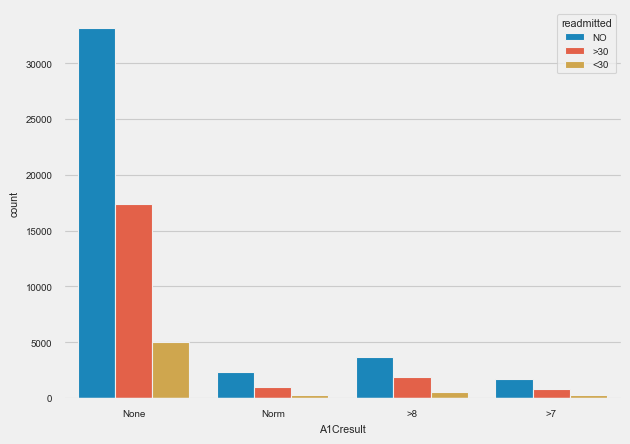

In [50]:
sns.countplot(x=df_train.A1Cresult,hue=df_train.readmitted)

+ `change`

<AxesSubplot:xlabel='change', ylabel='count'>

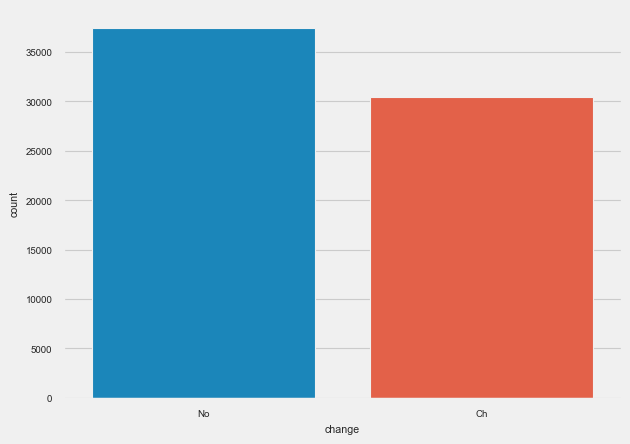

In [51]:
sns.countplot(x=df_train.change)

<AxesSubplot:xlabel='change', ylabel='count'>

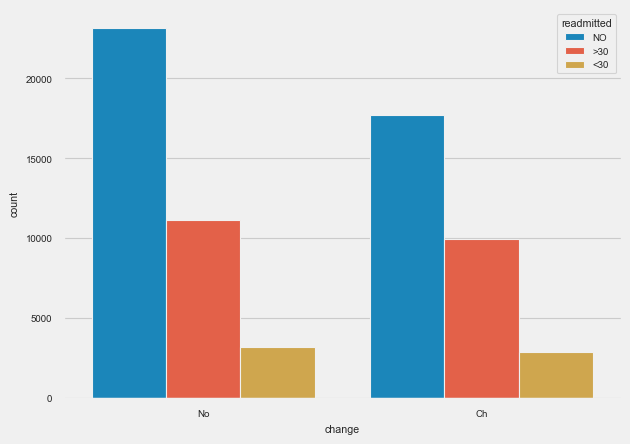

In [52]:
sns.countplot(x=df_train.change,hue=df_train.readmitted)

+ `diabetesMed`
- Of all the patients, around 77% have prescribed diabetic medication.

In [53]:
round(df_train['diabetesMed'].value_counts(normalize=True)*100, 2)

Yes    76.02
No     23.98
Name: diabetesMed, dtype: float64

<AxesSubplot:xlabel='diabetesMed', ylabel='count'>

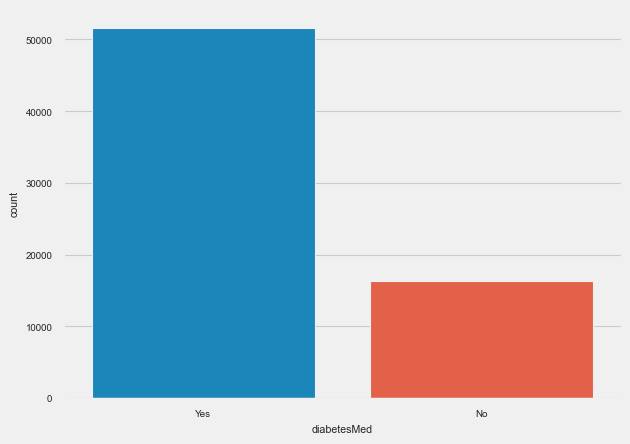

In [54]:
sns.countplot(x=df_train.diabetesMed)

<AxesSubplot:xlabel='diabetesMed', ylabel='count'>

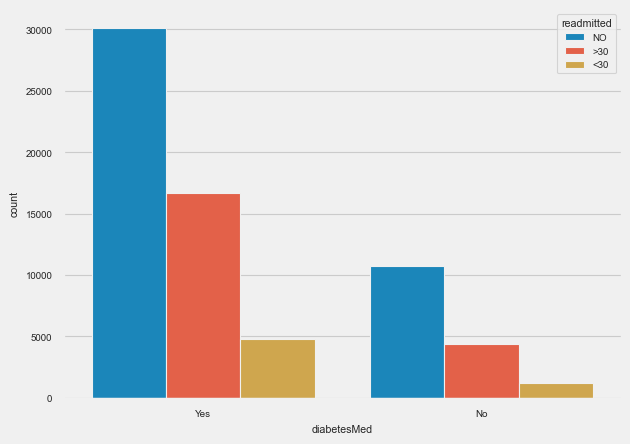

In [55]:
sns.countplot(x=df_train.diabetesMed,hue=df_train.readmitted)

+ features for medications
- Features from `metformin` up till `metformin-pioglitazone` are medications that treat diabetes. The categories for these variables are:
    + “up” if the dosage was increased during the encounter,
    + “down” if the dosage was decreased, “steady” if the dosage did not change, and
    + “no” if the drug was not prescribed.
- We will make a separate table to examine these 23 features and examine distribution for each of the features.

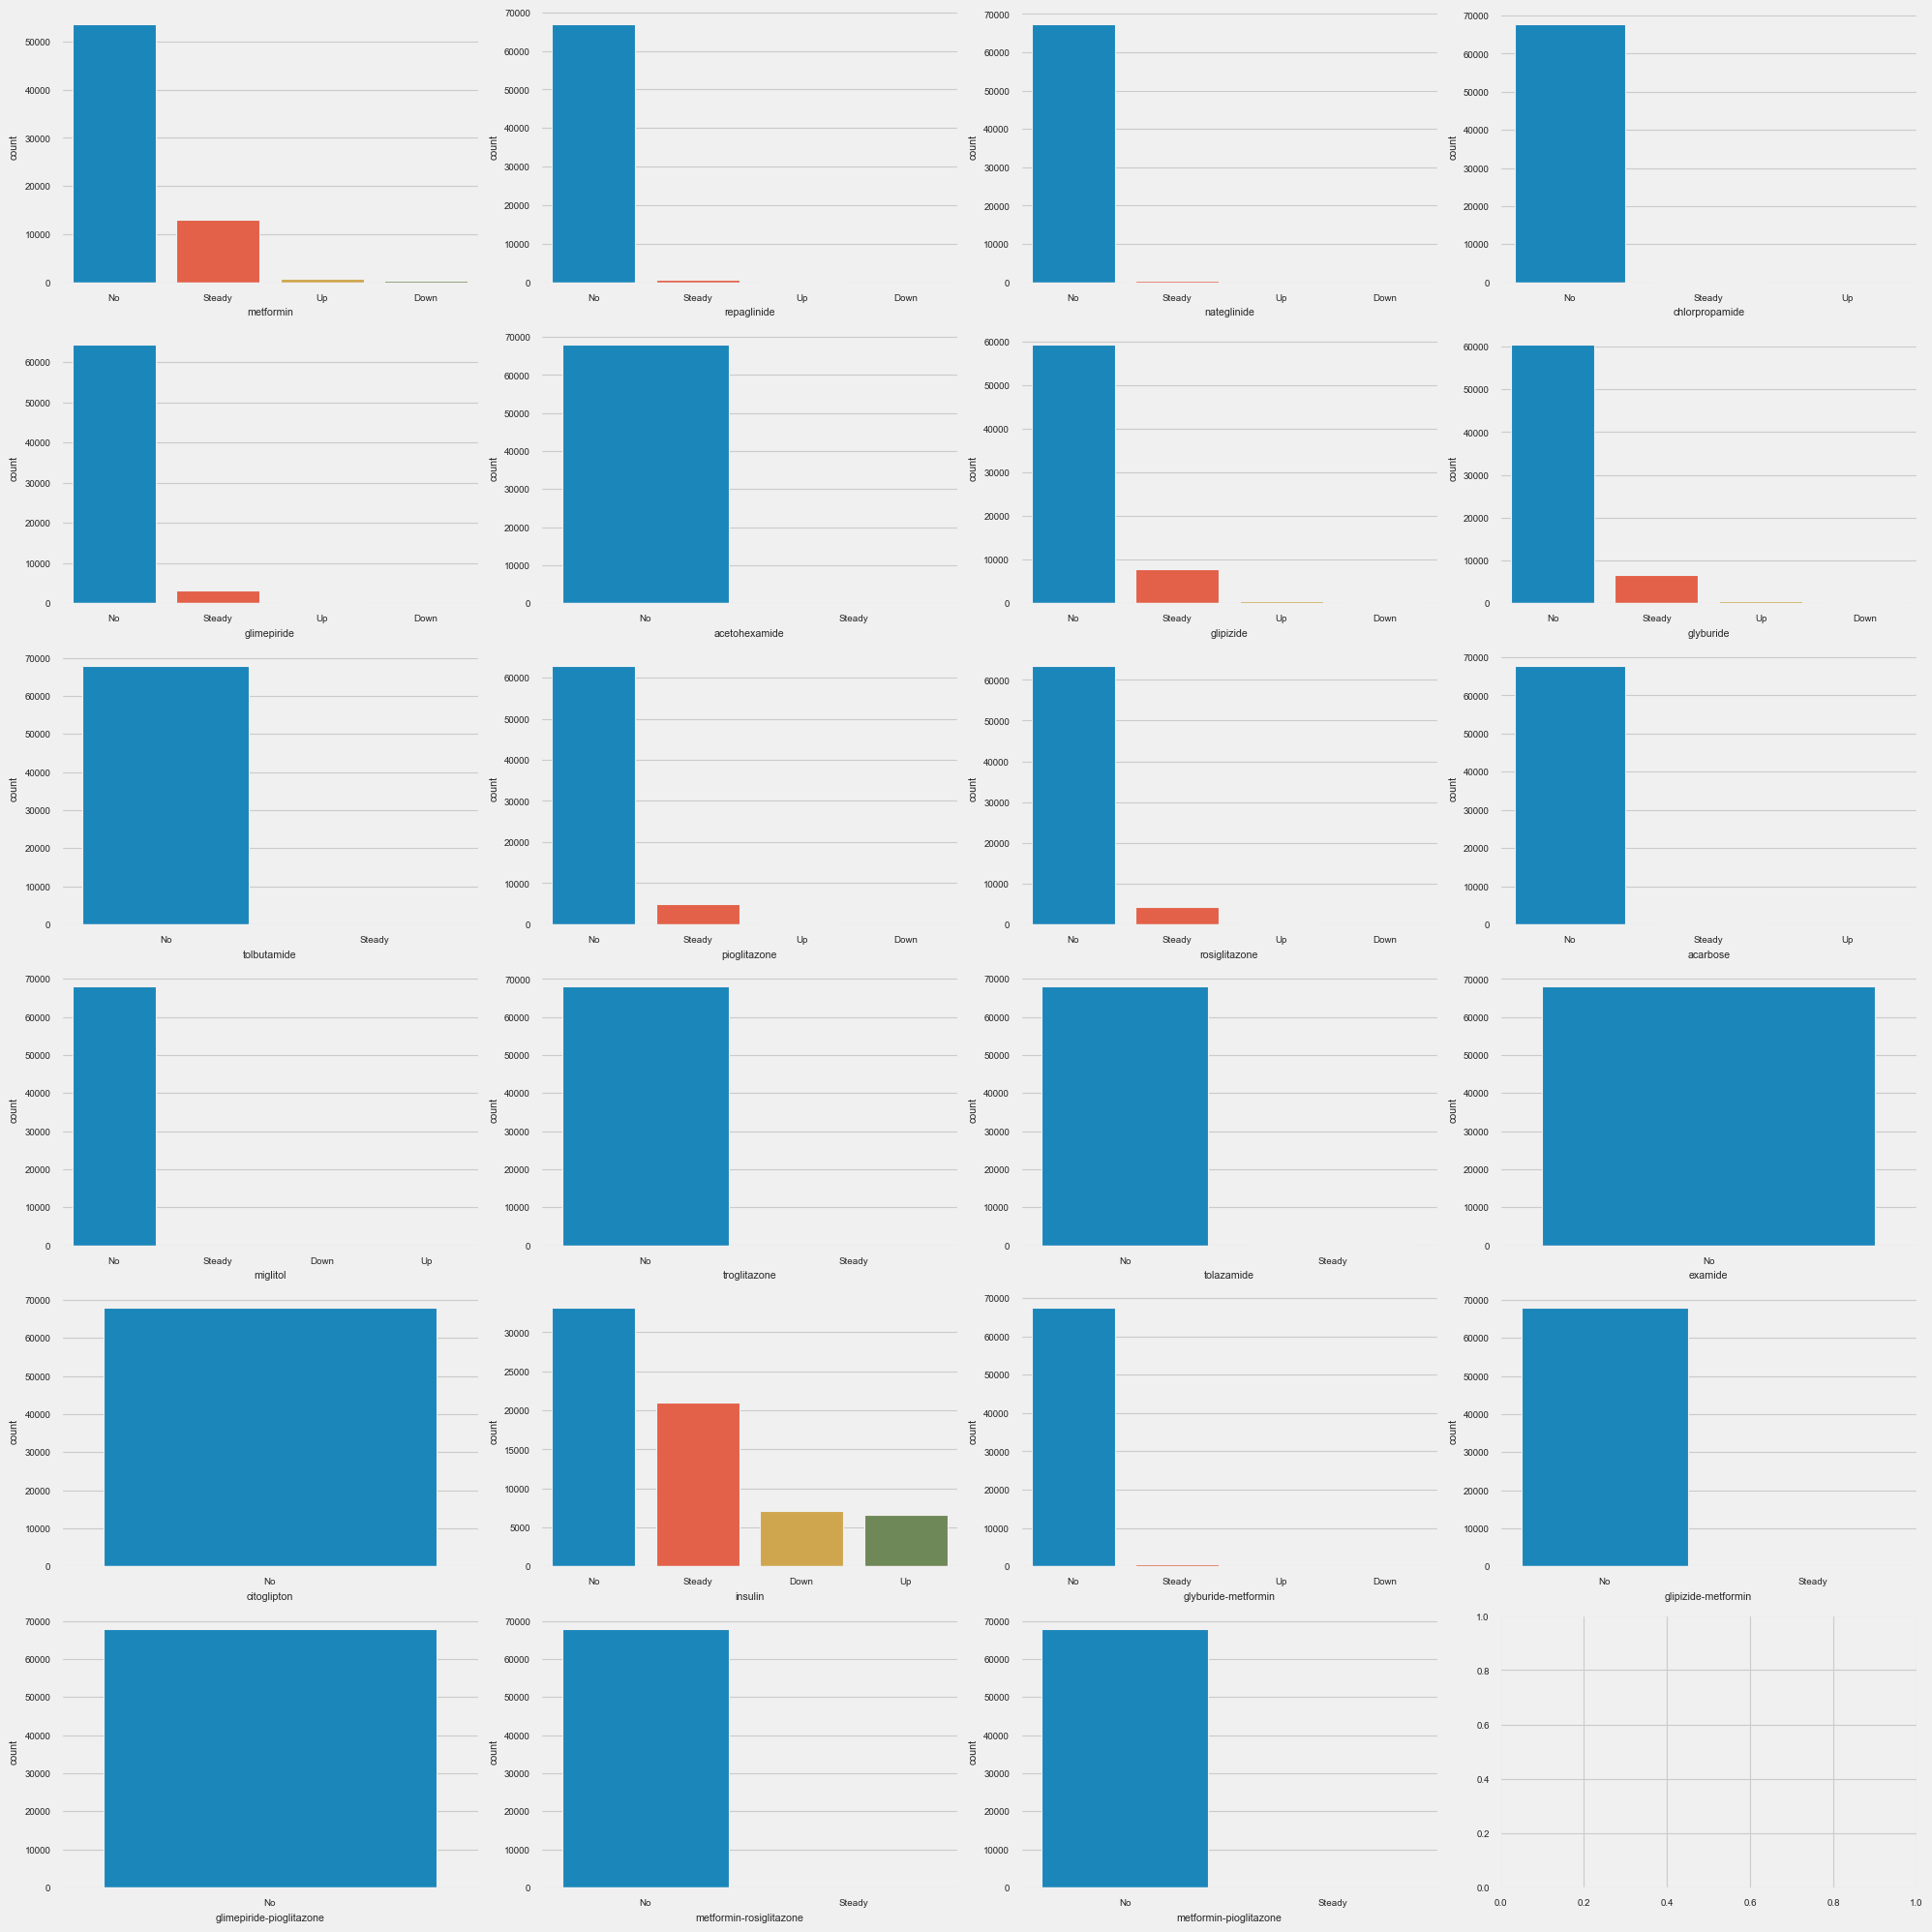

In [56]:
medications_df_train = df_train.iloc[:, df_train.columns.get_loc('metformin') : df_train.columns.get_loc('metformin-pioglitazone')+1]
medications_df_test = df_test.iloc[:, df_test.columns.get_loc('metformin') : df_test.columns.get_loc('metformin-pioglitazone')+1]
n_cols = 4
fig, subplots = plt.subplots(int(np.ceil(medications_df_train.shape[1]/n_cols)), n_cols, figsize=(20, 20))

for ax, medication in zip(subplots.flatten(), medications_df_train):
  sns.countplot(x=medications_df_train[medication], order=medications_df_train[medication].value_counts().index, ax=ax)

plt.tight_layout()

- We can see that `examide` and `citoglipton` do not have any changes. So, we can drop these 2 columns.

In [57]:
df_train = df_train.drop(['examide','citoglipton'],axis=1)
df_test = df_test.drop(['examide','citoglipton'],axis=1)

medications_df_train = medications_df_train.drop(['examide','citoglipton'],axis=1)
medications_df_test = medications_df_test.drop(['examide','citoglipton'],axis=1)

- We still have 21 medications left, a lot of which are not used for the majority of the patients. Let's check out the percentage of change in each of these medications.

In [58]:
medications_percentages_df_train = (medications_df_train.apply(pd.Series.value_counts)/len(df_train)*100).T
medications_percentages_df_test = (medications_df_test.apply(pd.Series.value_counts)/len(df_test)*100).T
medications_percentages_df_train

,Down,No,Steady,Up
metformin,0.610815,79.026228,19.181066,1.181890
repaglinide,0.041212,98.716552,1.142151,0.100085
nateglinide,0.011775,99.303818,0.660858,0.023549
chlorpropamide,NaN,99.895499,0.098614,0.005887
glimepiride,0.192812,94.739631,4.737865,0.329693
acetohexamide,NaN,99.998528,0.001472,NaN
glipizide,0.528392,87.242059,11.424450,0.805098
glyburide,0.593153,88.953814,9.590533,0.862500
tolbutamide,NaN,99.973507,0.026493,NaN
pioglitazone,0.111860,92.545112,7.088399,0.254629


In [59]:
medications_percentages_df_test

,Down,No,Steady,Up
metformin,0.559284,79.278523,19.183445,0.978747
repaglinide,0.027964,98.489933,1.342282,0.139821
nateglinide,NaN,99.300895,0.699105,NaN
chlorpropamide,0.027964,99.972036,NaN,NaN
glimepiride,0.195749,95.218121,4.278523,0.307606
acetohexamide,NaN,100.000000,NaN,NaN
glipizide,0.531320,87.751678,10.850112,0.866890
glyburide,0.503356,90.240492,8.277405,0.978747
tolbutamide,NaN,99.972036,0.027964,NaN
pioglitazone,0.139821,93.204698,6.459732,0.195749


- Let's focus on medications with more than 10% patients prescribed the medications, which will be `metformin`, `glipizide`, `glyburide` and `insulin`. We will drop all other medications.

In [60]:
medications_to_drop_train = medications_percentages_df_train[medications_percentages_df_train.drop(columns='No').sum(1).values < 10].index
medications_to_drop_test = medications_percentages_df_test[medications_percentages_df_test.drop(columns='No').sum(1).values < 10].index
medications_to_drop_test = medications_to_drop_test.drop('glyburide')
df_train = df_train.drop(columns=medications_to_drop_train)
df_test = df_test.drop(columns=medications_to_drop_test)

medications_df_train = medications_df_train.drop(columns=medications_to_drop_train)
medications_df_test = medications_df_test.drop(columns=medications_to_drop_test)

- Here we are keeping out the `glyburide` because in the test set the `glyburide` does not have more than 10% prescribed. But to keep the consistency in the train set and test set, we will manually keep this feature so that we would not run into weird error in modeling part.

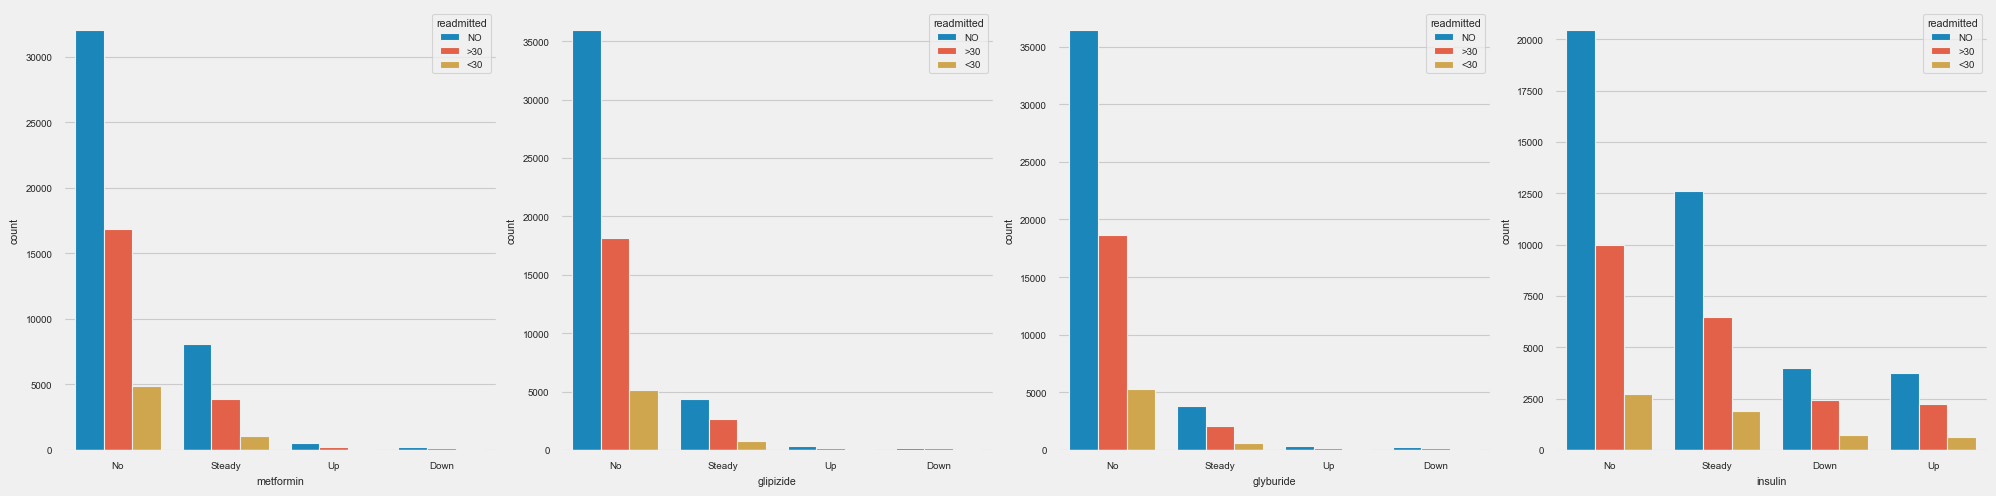

In [61]:
n_cols = 4
fig, subplots = plt.subplots(int(np.ceil(medications_df_train.shape[1]/n_cols)), n_cols, figsize=(20, 5))

for ax, medication in zip(subplots.flatten(), medications_df_train):
  sns.countplot(x=medications_df_train[medication], order=medications_df_train[medication].value_counts().index, hue=df_train['readmitted'], ax=ax)

plt.tight_layout()

+ `Total_number_change`

In [62]:
medications_value_counts_df_train = (df_train[['metformin', 'glipizide', 'insulin','glyburide']]).apply(pd.Series.value_counts, axis=1)
medications_value_counts_df_test = (df_test[['metformin', 'glipizide', 'insulin','glyburide']]).apply(pd.Series.value_counts, axis=1)

medications_value_counts_df_test.head()

,Down,No,Steady,Up
39874,NaN,4.0,NaN,NaN
20996,NaN,2.0,2.0,NaN
35609,NaN,4.0,NaN,NaN
93210,NaN,3.0,1.0,NaN
54698,NaN,4.0,NaN,NaN


In [63]:
df_train['number_changes'] = medications_value_counts_df_train[['Down', 'Up']].sum(1).astype('int')
df_test['number_changes'] = medications_value_counts_df_test[['Down', 'Up']].sum(1).astype('int')

- Let's drop `change` since this is more representative.

In [64]:
df_train = df_train.drop(['change'],axis=1)
df_test = df_test.drop(['change'],axis=1)

<AxesSubplot:xlabel='number_changes', ylabel='count'>

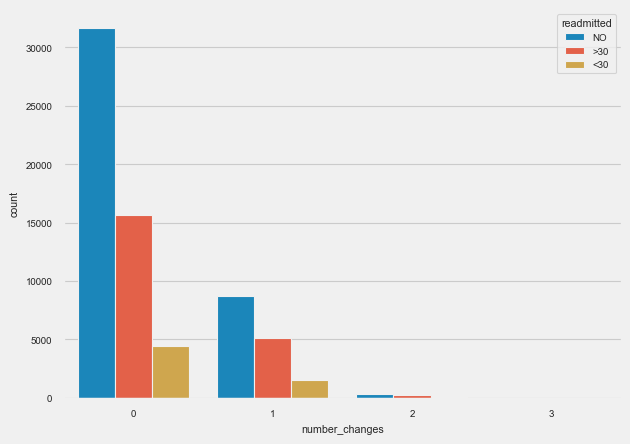

In [65]:
sns.countplot(data=df_train, x='number_changes',hue='readmitted')

### 2.3 One-hot encoding for Y value

In [66]:
readmitt_map = {
    'NO':0,
    '''>30''' :1,
    '''<30''' :2,
}

df_train['readmitted'] = df_train['readmitted'].map(readmitt_map)
df_test['readmitted'] = df_test['readmitted'].map(readmitt_map)
df_train['readmitted']

22686    0
42777    1
67524    0
70812    1
32663    0
        ..
48580    0
7501     0
75170    0
906      0
20791    0
Name: readmitted, Length: 67942, dtype: int64

In [67]:
# grouped_df = df_train.groupby('readmitted')
# count_df = grouped_df.size().reset_index(name='count')
# sorted_df = count_df.sort_values(['count', 'readmitted'], ascending=[False, True])
# sorted_df

#### 2.4 Catboost for diabetesMed and 24 features

In [68]:
# df_24feature = df_train[['metformin', 'repaglinide', 'nateglinide',
#        'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
#        'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
#        'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
#        'insulin', 'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone']]
# df_24feature_y = df_train['diabetesMed']

In [69]:
# from catboost import CatBoostClassifier
# import numpy as np
# import pandas as pd
# from sklearn.metrics import accuracy_score
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
#
# # generate a synthetic dataset
# cat_features = ['metformin', 'repaglinide', 'nateglinide',
#        'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
#        'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
#        'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
#        'insulin', 'glyburide-metformin', 'glipizide-metformin',
#        'glimepiride-pioglitazone', 'metformin-rosiglitazone',
#        'metformin-pioglitazone']
#
# # Convert categorical columns to category dtype
# for column in cat_features:
#     df_24feature[column] = df_24feature[column].astype('category')
#
#
# # split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(df_24feature, df_24feature_y, test_size=0.2, random_state=42)
#
# model = CatBoostClassifier(iterations=500,
#                            learning_rate=0.1,
#                            depth=5,
#                            cat_features=cat_features,
#                            loss_function='Logloss')
#
# # Fit model
# model.fit(X_train, y_train, verbose=100)
#
# # Get predictions
# preds = model.predict(X_test)
#
# # Evaluate model
# print(f'Accuracy: {accuracy_score(y_test, preds)}')

In [70]:
# len(cat_features)

#### 2.4 Correlation Map

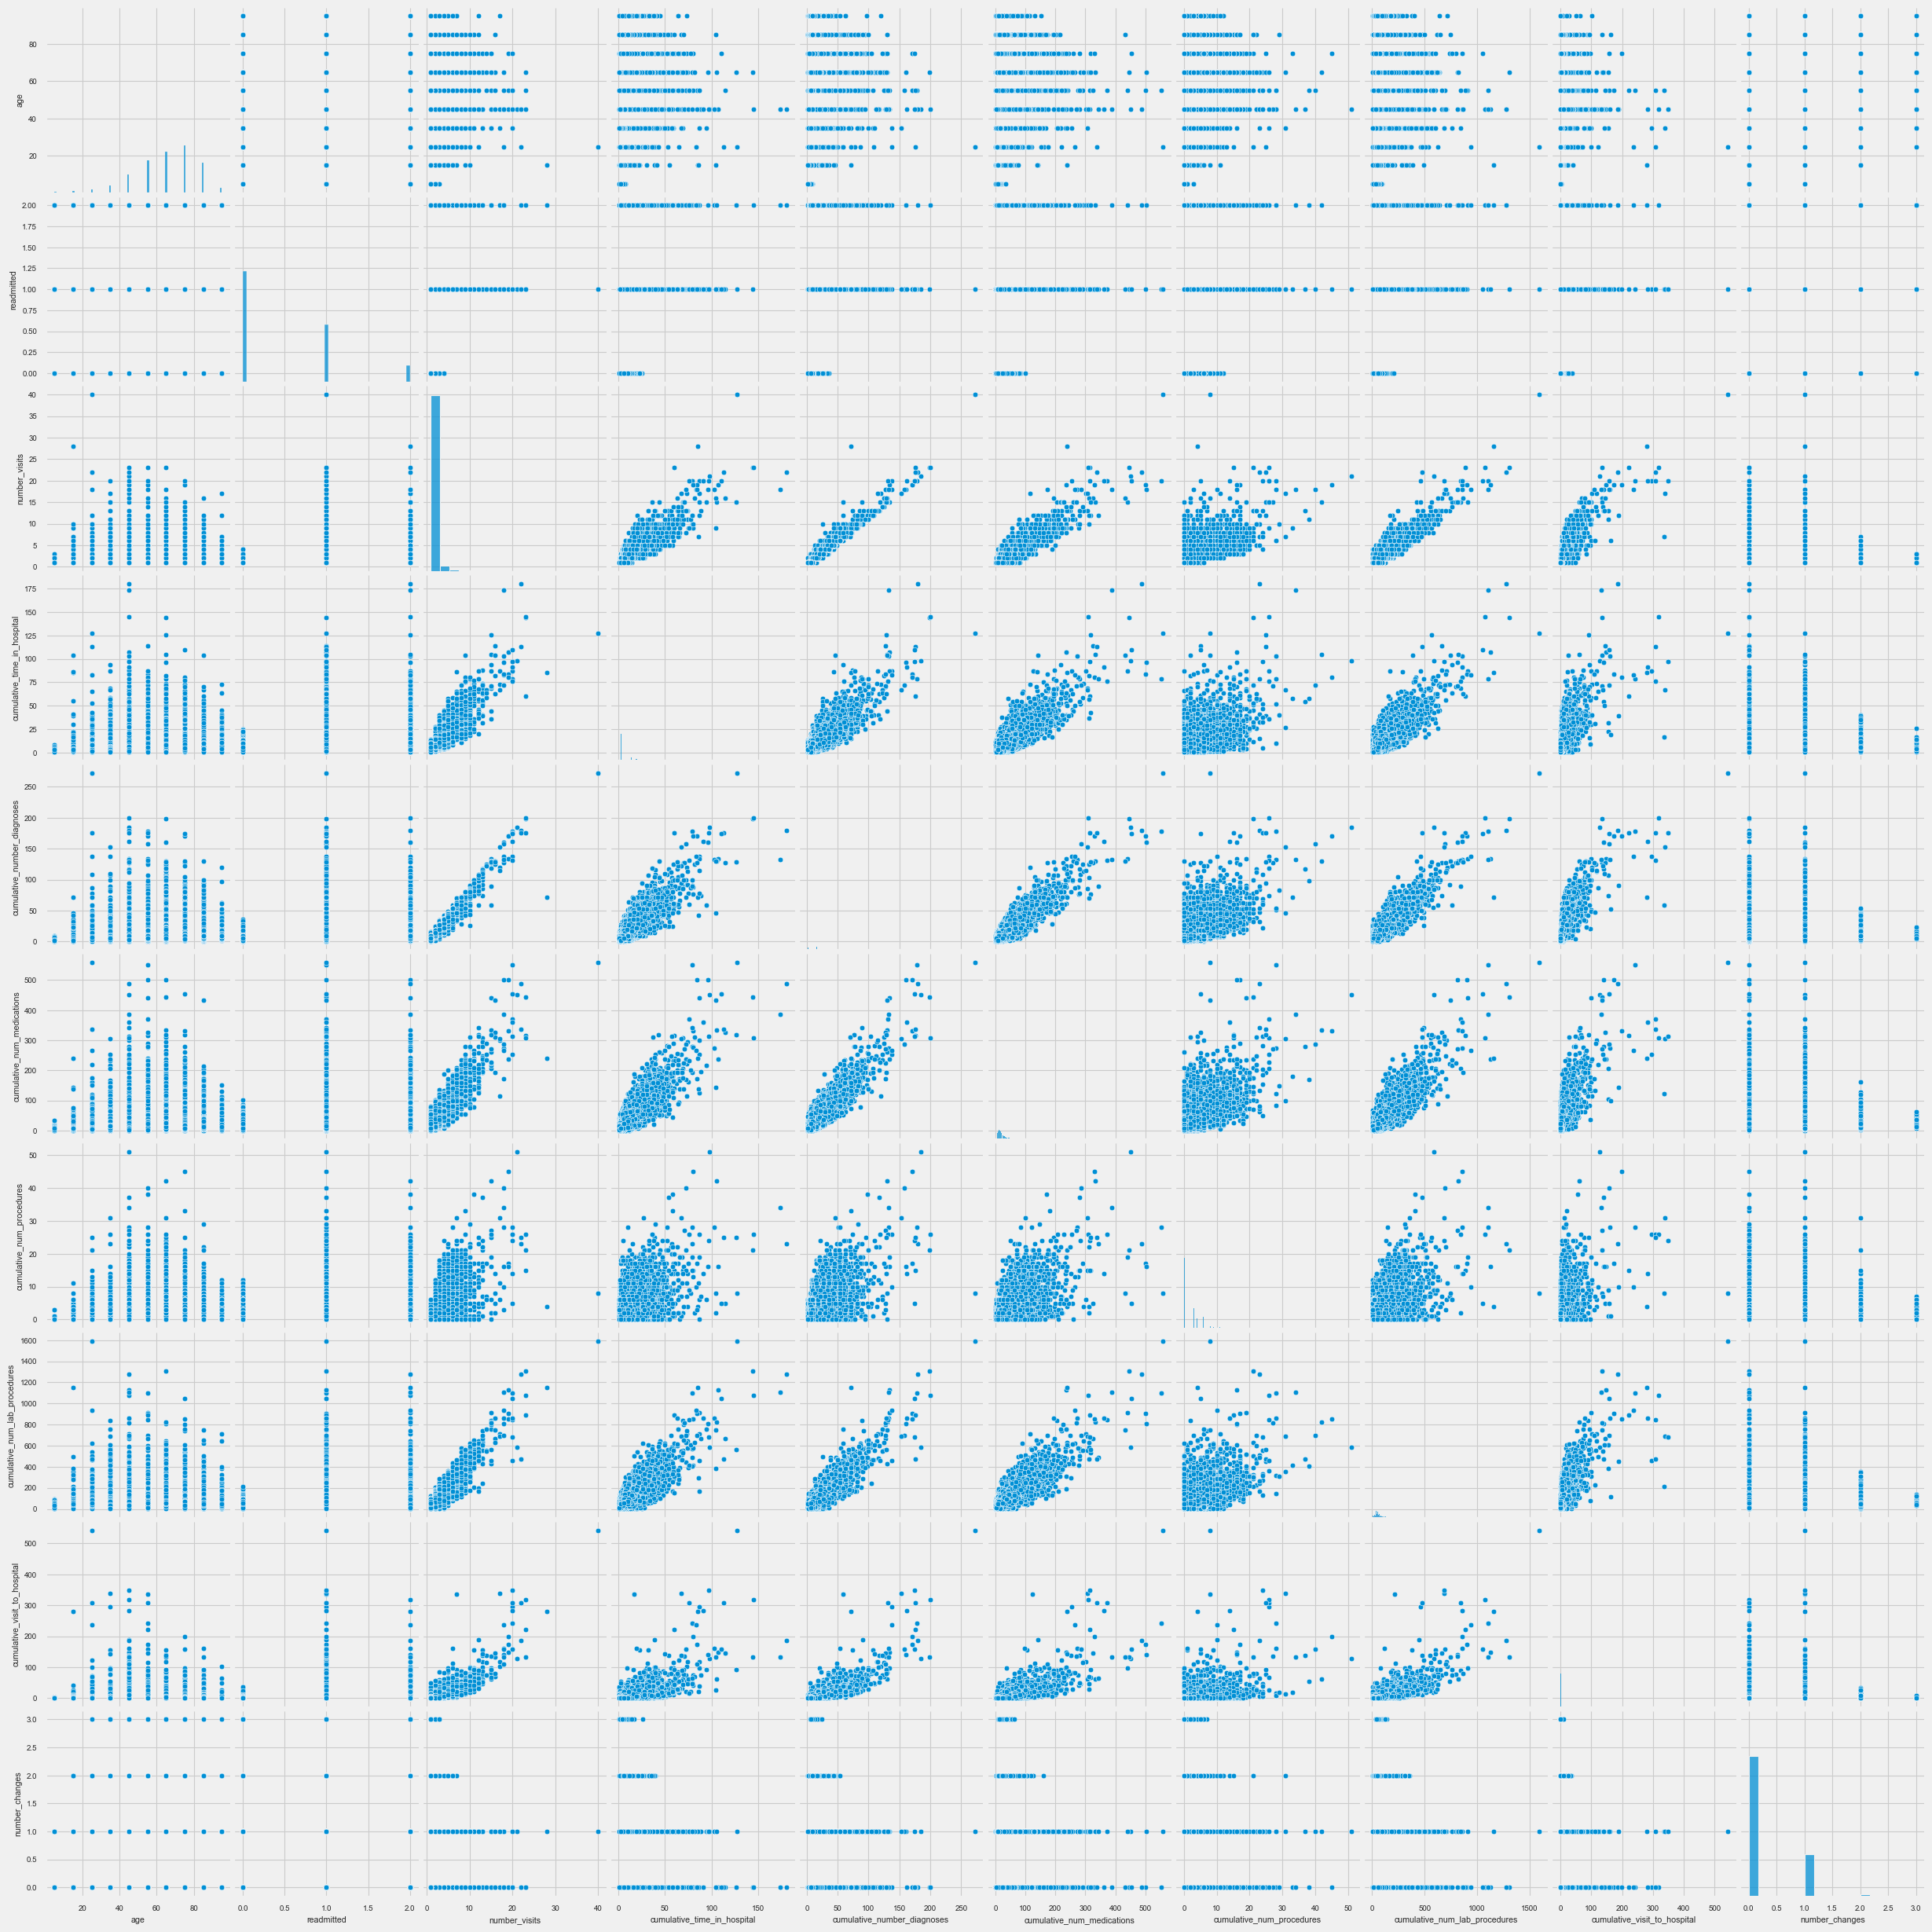

In [71]:
sns.pairplot(df_train)

#### 2.5 Visualization

## 3. Model Construction
### 3.1 Dataset preparation for sklearn ML models
- For variables `race`, `gender`, `diag_1`, `diag_2`, `diag_3`, `max_glu_serum`, `A1Cresult`, `change`, and `diabetesMed`, we need to make them dummy variables so that we could feed sklearn models with our data.

In [72]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67942 entries, 22686 to 20791
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   race                           67942 non-null  object
 1   gender                         67942 non-null  object
 2   age                            67942 non-null  int64 
 3   admission_type_id              67942 non-null  object
 4   discharge_disposition_id       67942 non-null  object
 5   admission_source_id            67942 non-null  object
 6   diag_1                         67942 non-null  object
 7   diag_2                         67942 non-null  object
 8   diag_3                         67942 non-null  object
 9   max_glu_serum                  67942 non-null  object
 10  A1Cresult                      67942 non-null  object
 11  metformin                      67942 non-null  object
 12  glipizide                      67942 non-null  object
 1

In [73]:
# race
race_df_train = pd.get_dummies(df_train['race'], drop_first=True)
df_train[race_df_train.columns] = race_df_train
df_train = df_train.drop(columns='race')

race_df_test = pd.get_dummies(df_test['race'], drop_first=True)
df_test[race_df_test.columns] = race_df_test
df_test = df_test.drop(columns='race')

# gender
df_train['gender'] = df_train['gender'].replace({'Female' : 0, 'Male' : 1})
df_test['gender'] = df_test['gender'].replace({'Female' : 0, 'Male' : 1})

# admission_type_id
age_df_train = pd.get_dummies(df_train['age'], drop_first=True)
df_train[age_df_train.columns] = age_df_train
df_train = df_train.drop(columns='age')

age_df_test = pd.get_dummies(df_test['age'], drop_first=True)
df_test[age_df_test.columns] = age_df_test
df_test = df_test.drop(columns='age')

# admission_type_id
ad_type_id_df_train = pd.get_dummies(df_train['admission_type_id'], drop_first=True)
df_train[ad_type_id_df_train.columns] = ad_type_id_df_train
df_train = df_train.drop(columns='admission_type_id')

ad_type_id_df_test = pd.get_dummies(df_test['admission_type_id'], drop_first=True)
df_test[ad_type_id_df_test.columns] = ad_type_id_df_test
df_test = df_test.drop(columns='admission_type_id')

# discharge_disposition_id
dis_dis_id_df_train = pd.get_dummies(df_train['discharge_disposition_id'], drop_first=True)
df_train[dis_dis_id_df_train.columns] = dis_dis_id_df_train
df_train = df_train.drop(columns='discharge_disposition_id')

dis_dis_id_df_test = pd.get_dummies(df_test['discharge_disposition_id'], drop_first=True)
df_test[dis_dis_id_df_test.columns] = dis_dis_id_df_test
df_test = df_test.drop(columns='discharge_disposition_id')

# admission_source_id
ad_source_id_df_train = pd.get_dummies(df_train['admission_source_id'], drop_first=True)
df_train[ad_source_id_df_train.columns] = ad_source_id_df_train
df_train = df_train.drop(columns='admission_source_id')

ad_source_id_df_test = pd.get_dummies(df_test['admission_source_id'], drop_first=True)
df_test[ad_source_id_df_test.columns] = ad_source_id_df_test
df_test = df_test.drop(columns='admission_source_id')

# diag_1
diag_1_df_train = pd.get_dummies(df_train['diag_1'], drop_first=True)
df_train[diag_1_df_train.columns] = diag_1_df_train
df_train = df_train.drop(columns='diag_1')

diag_1_df_test = pd.get_dummies(df_test['diag_1'], drop_first=True)
df_test[diag_1_df_test.columns] = diag_1_df_test
df_test = df_test.drop(columns='diag_1')

# diag_2
diag_2_df_train = pd.get_dummies(df_train['diag_2'], drop_first=True)
df_train[diag_2_df_train.columns] = diag_2_df_train
df_train = df_train.drop(columns='diag_2')

diag_2_df_test = pd.get_dummies(df_test['diag_2'], drop_first=True)
df_test[diag_2_df_test.columns] = diag_2_df_test
df_test = df_test.drop(columns='diag_2')

# diag_3
diag_3_df_train = pd.get_dummies(df_train['diag_3'], drop_first=True)
df_train[diag_3_df_train.columns] = diag_3_df_train
df_train = df_train.drop(columns='diag_3')

diag_3_df_test = pd.get_dummies(df_test['diag_3'], drop_first=True)
df_test[diag_3_df_test.columns] = diag_3_df_test
df_test = df_test.drop(columns='diag_3')

# max_glu_serum
glu_serum_df_train = pd.get_dummies(df_train['max_glu_serum'], drop_first=True)
df_train[glu_serum_df_train.columns] = glu_serum_df_train
df_train = df_train.drop(columns='max_glu_serum')

glu_serum_df_test = pd.get_dummies(df_test['max_glu_serum'], drop_first=True)
df_test[glu_serum_df_test.columns] = glu_serum_df_test
df_test = df_test.drop(columns='max_glu_serum')

# A1Cresult
A1C_df_train = pd.get_dummies(df_train['A1Cresult'], drop_first=True)
df_train[A1C_df_train.columns] = A1C_df_train
df_train = df_train.drop(columns='A1Cresult')

A1C_df_test = pd.get_dummies(df_test['A1Cresult'], drop_first=True)
df_test[A1C_df_test.columns] = A1C_df_test
df_test = df_test.drop(columns='A1Cresult')

# metformin
metformin_df_train = pd.get_dummies(df_train['metformin'], drop_first=True)
df_train[metformin_df_train.columns] = metformin_df_train
df_train = df_train.drop(columns='metformin')

metformin_df_test = pd.get_dummies(df_test['metformin'], drop_first=True)
df_test[metformin_df_test.columns] = metformin_df_test
df_test = df_test.drop(columns='metformin')

# glipizide
glipizide_df_train = pd.get_dummies(df_train['glipizide'], drop_first=True)
df_train[glipizide_df_train.columns] = glipizide_df_train
df_train = df_train.drop(columns='glipizide')

glipizide_df_test = pd.get_dummies(df_test['glipizide'], drop_first=True)
df_test[glipizide_df_test.columns] = glipizide_df_test
df_test = df_test.drop(columns='glipizide')

# insulin
insulin_df_train = pd.get_dummies(df_train['insulin'], drop_first=True)
df_train[insulin_df_train.columns] = insulin_df_train
df_train = df_train.drop(columns='insulin')

insulin_df_test = pd.get_dummies(df_test['insulin'], drop_first=True)
df_test[insulin_df_test.columns] = insulin_df_test
df_test = df_test.drop(columns='insulin')

# glyburide
glyburide_df_train = pd.get_dummies(df_train['glyburide'], drop_first=True)
df_train[glyburide_df_train.columns] = glyburide_df_train
df_train = df_train.drop(columns='glyburide')

glyburide_df_test = pd.get_dummies(df_test['glyburide'], drop_first=True)
df_test[glyburide_df_test.columns] = glyburide_df_test
df_test = df_test.drop(columns='glyburide')

# diabetesMed
diabetesMed_df_train = pd.get_dummies(df_train['diabetesMed'], drop_first=True)
df_train[diabetesMed_df_train.columns] = diabetesMed_df_train
df_train = df_train.drop(columns='diabetesMed')

diabetesMed_df_test = pd.get_dummies(df_test['diabetesMed'], drop_first=True)
df_test[diabetesMed_df_test.columns] = diabetesMed_df_test
df_test = df_test.drop(columns='diabetesMed')

In [74]:
df_train.readmitted = df_train.readmitted.astype('int')
df_test.readmitted = df_test.readmitted.astype('int')
df_train.columns = df_train.columns.astype('str')
df_test.columns = df_test.columns.astype('str')

In [75]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67942 entries, 22686 to 20791
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   gender                         67942 non-null  int64
 1   readmitted                     67942 non-null  int32
 2   number_visits                  67942 non-null  int64
 3   cumulative_time_in_hospital    67942 non-null  int64
 4   cumulative_number_diagnoses    67942 non-null  int64
 5   cumulative_num_medications     67942 non-null  int64
 6   cumulative_num_procedures      67942 non-null  int64
 7   cumulative_num_lab_procedures  67942 non-null  int64
 8   cumulative_visit_to_hospital   67942 non-null  int64
 9   number_changes                 67942 non-null  int32
 10  Caucasian                      67942 non-null  uint8
 11  Other                          67942 non-null  uint8
 12  15                             67942 non-null  uint8
 13  25          

In [76]:
df_train.corr()

,gender,readmitted,number_visits,cumulative_time_in_hospital,cumulative_number_diagnoses,cumulative_num_medications,cumulative_num_procedures,cumulative_num_lab_procedures,cumulative_visit_to_hospital,number_changes,...,other,respiratory,>300,None,Norm,>8,No,Steady,Up,Yes
gender,1.000000,-0.012554,-0.015684,-0.031021,-0.014561,-0.024258,0.049900,-1.607623e-02,-0.014054,0.010839,...,-0.014969,0.004041,1.710383e-03,-0.023445,0.000374,0.025775,-0.034230,0.031815,0.010450,0.018376
readmitted,-0.012554,1.000000,0.446486,0.385963,0.437949,0.387746,0.203892,4.068206e-01,0.217176,0.037941,...,-0.009489,0.014318,1.299638e-02,0.017350,-0.016248,-0.006706,-0.011135,0.008578,0.003970,0.060075
number_visits,-0.015684,0.446486,1.000000,0.796641,0.953805,0.859365,0.430222,8.696075e-01,0.724778,0.052610,...,-0.003639,0.014447,2.850834e-02,0.011476,-0.020752,0.003098,-0.000200,-0.002614,0.004254,0.035135
cumulative_time_in_hospital,-0.031021,0.385963,0.796641,1.000000,0.794715,0.813167,0.436115,7.857963e-01,0.563377,0.108397,...,-0.000531,0.042896,3.764783e-02,-0.023213,0.004341,0.018871,-0.016153,0.002906,0.022693,0.055557
cumulative_number_diagnoses,-0.014561,0.437949,0.953805,0.794715,1.000000,0.865741,0.438755,8.506073e-01,0.694969,0.065929,...,0.003493,0.038519,1.984491e-02,0.013411,-0.011424,-0.012629,0.005285,-0.007973,0.002976,0.037051
cumulative_num_medications,-0.024258,0.387746,0.859365,0.813167,0.865741,1.000000,0.533919,8.062778e-01,0.632988,0.136357,...,-0.032240,0.048523,2.753769e-02,0.006207,-0.014109,-0.000715,-0.016828,0.010438,0.011758,0.106907
cumulative_num_procedures,0.049900,0.203892,0.430222,0.436115,0.438755,0.533919,1.000000,3.962841e-01,0.287989,0.032393,...,-0.065446,0.003268,-2.291387e-02,0.027494,-0.021233,-0.015558,-0.004224,0.002016,0.003318,0.009432
cumulative_num_lab_procedures,-0.016076,0.406821,0.869608,0.785796,0.850607,0.806278,0.396284,1.000000e+00,0.630344,0.088511,...,0.001360,0.030997,3.110155e-04,-0.101233,0.034764,0.082356,0.000833,-0.008577,0.012100,0.044052
cumulative_visit_to_hospital,-0.014054,0.217176,0.724778,0.563377,0.694969,0.632988,0.287989,6.303439e-01,1.000000,0.040427,...,0.006017,0.010770,2.810828e-02,0.014221,-0.018439,0.000933,0.010389,-0.011163,-0.002550,0.026406
number_changes,0.010839,0.037941,0.052610,0.108397,0.065929,0.136357,0.032393,8.851062e-02,0.040427,1.000000,...,0.031784,0.015501,6.060899e-02,-0.121737,0.004379,0.156454,-0.033968,-0.071803,0.206293,0.304988


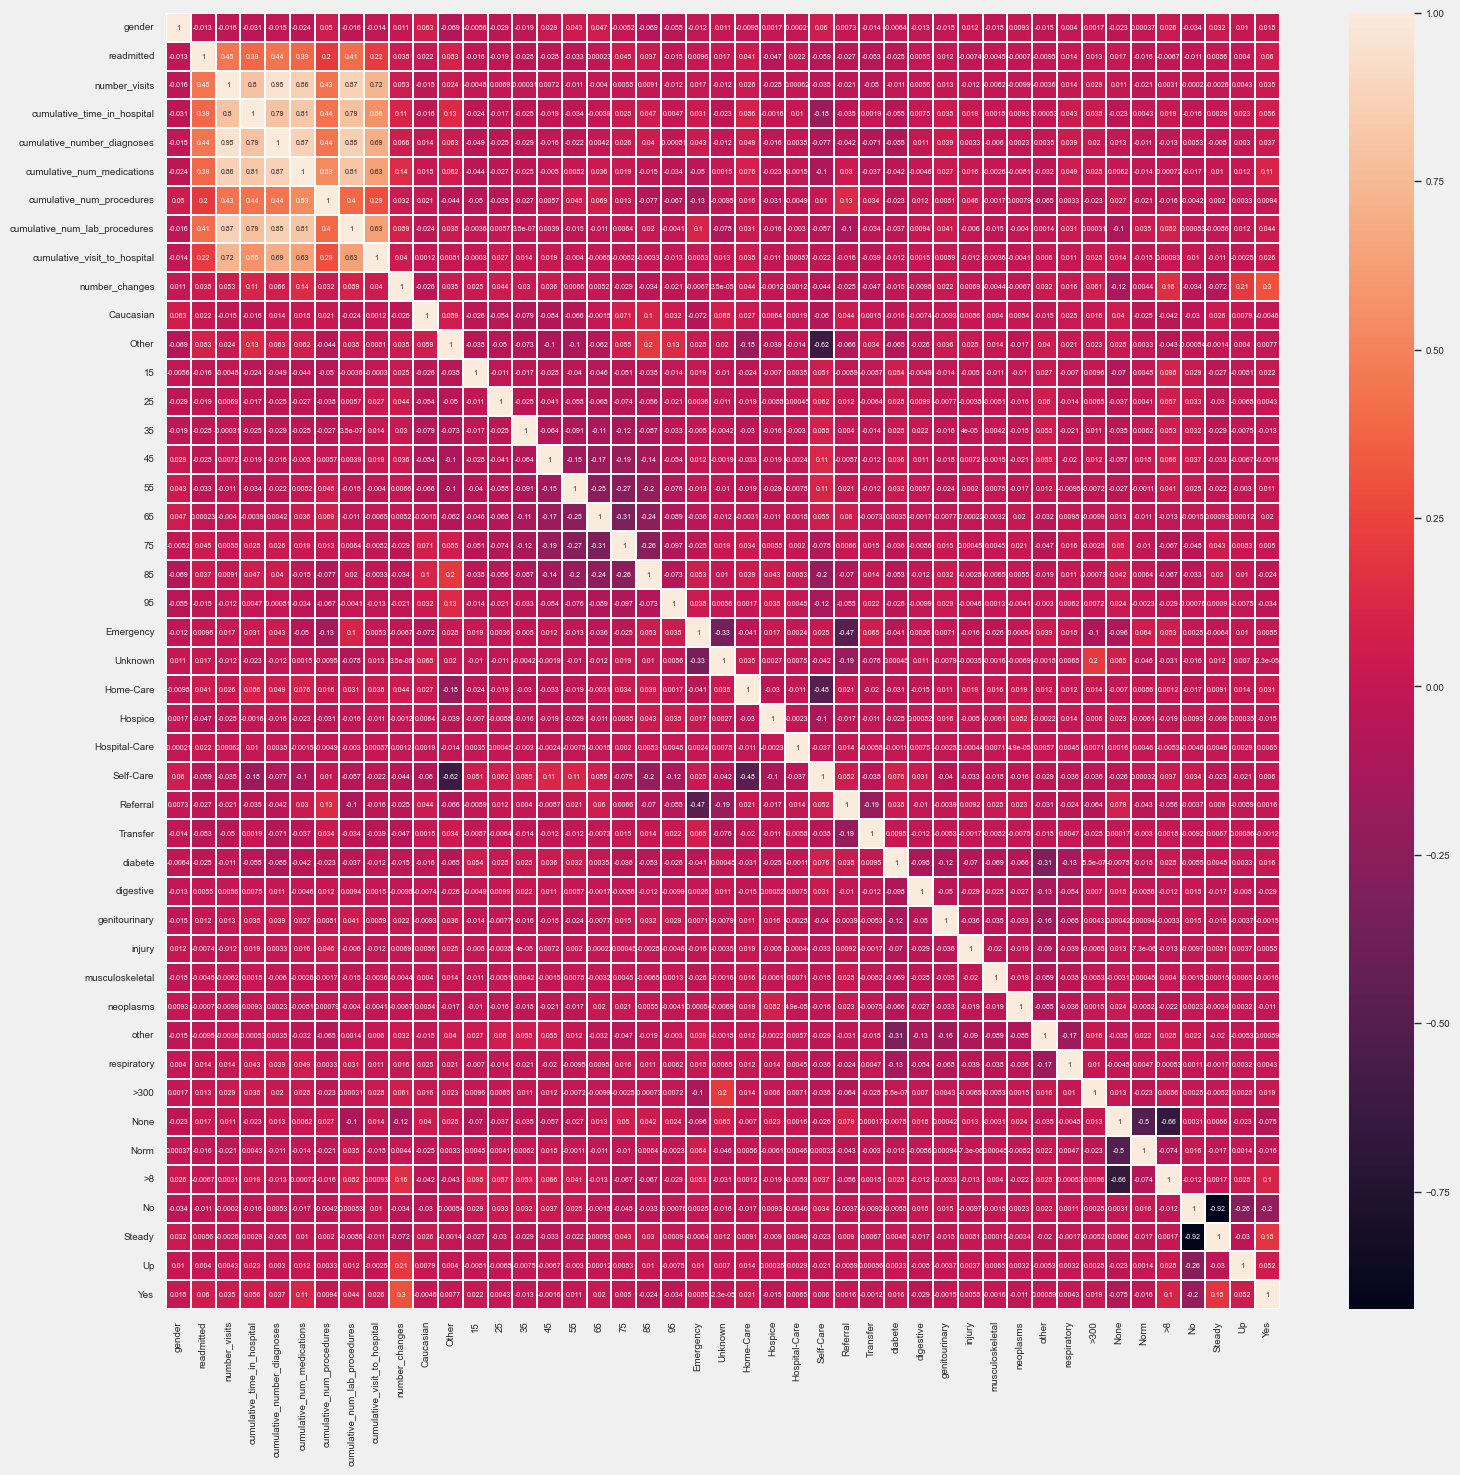

In [79]:
corr = df_train.corr()
sns.heatmap(corr,xticklabels=corr.columns,
        yticklabels=corr.columns,
            annot=True,linewidths=0.2,annot_kws={'size':5})
fig=plt.gcf()
fig.set_size_inches(16,16)
plt.show()

In [373]:
trainX = df_train[df_train.columns.drop('readmitted')]
trainY = pd.DataFrame(df_train['readmitted'])
testX = df_test[df_test.columns.drop('readmitted')]
testY = pd.DataFrame(df_test['readmitted'])

In [374]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import classification_report

In [376]:
gnb = GaussianNB()
gnb.fit(trainX,trainY)
lda = LinearDiscriminantAnalysis()
lda.fit(trainX,trainY)
lr = LogisticRegression(max_iter=2000)
lr.fit(trainX,trainY)
tr = DecisionTreeClassifier(min_samples_split=50)
tr.fit(trainX,trainY)
forest = RandomForestClassifier(random_state=42, min_samples_split=50)
forest.fit(trainX,trainY)

# Assess accuracies.

print("Initial fits training Accuracy:")
print("gnb train:", classification_report(trainY, gnb.predict(trainX)))
print("lda train:", classification_report(trainY, lda.predict(trainX)))
print("lr train:", classification_report(trainY, lr.predict(trainX)))
print("tr train:", classification_report(trainY, tr.predict(trainX)))
print("forest train:", classification_report(trainY, forest.predict(trainX)))

print("Initial fits test set Accuracy:")
print("gnb test:", classification_report(testY, gnb.predict(testX)))
print("lda test:", classification_report(testY, lda.predict(testX)))
print("lr test:", classification_report(testY, lr.predict(testX)))
print("tr test:", classification_report(testY, tr.predict(testX)))
print("forest test:", classification_report(testY, forest.predict(testX)))

Initial fits training Accuracy:
gnb train:               precision    recall  f1-score   support

           0       0.78      0.96      0.86     40833
           1       0.69      0.49      0.58     21093
           2       0.28      0.13      0.18      6016

    accuracy                           0.74     67942
   macro avg       0.59      0.53      0.54     67942
weighted avg       0.71      0.74      0.71     67942

lda train:               precision    recall  f1-score   support

           0       0.73      0.99      0.84     40833
           1       0.75      0.41      0.53     21093
           2       0.37      0.05      0.09      6016

    accuracy                           0.73     67942
   macro avg       0.62      0.49      0.49     67942
weighted avg       0.71      0.73      0.68     67942

lr train:               precision    recall  f1-score   support

           0       0.78      0.99      0.87     40833
           1       0.73      0.57      0.64     21093
           

In [81]:
from catboost import Pool, CatBoostClassifier, cv
catboost_classifier = CatBoostClassifier(iterations=1000,eval_metric='Accuracy',learning_rate=0.1, use_best_model=True, random_seed=42)
catboost_classifier.fit(trainX, trainY, eval_set=(testX, testY), verbose=100)

0:	learn: 0.7695534	test: 0.7768456	best: 0.7768456 (0)	total: 151ms	remaining: 2m 30s
100:	learn: 0.7723352	test: 0.7782438	best: 0.7782438 (84)	total: 1.15s	remaining: 10.2s
200:	learn: 0.7752936	test: 0.7776846	best: 0.7782438 (84)	total: 2.12s	remaining: 8.42s
300:	learn: 0.7778546	test: 0.7790828	best: 0.7799217 (284)	total: 3.29s	remaining: 7.65s
400:	learn: 0.7801654	test: 0.7790828	best: 0.7799217 (284)	total: 4.16s	remaining: 6.22s
500:	learn: 0.7826529	test: 0.7804810	best: 0.7807606 (497)	total: 5.07s	remaining: 5.05s
600:	learn: 0.7848459	test: 0.7810403	best: 0.7813199 (553)	total: 5.99s	remaining: 3.98s
700:	learn: 0.7869359	test: 0.7790828	best: 0.7813199 (553)	total: 6.88s	remaining: 2.93s
800:	learn: 0.7892320	test: 0.7788031	best: 0.7813199 (553)	total: 7.84s	remaining: 1.95s
900:	learn: 0.7911601	test: 0.7785235	best: 0.7813199 (553)	total: 8.89s	remaining: 977ms
999:	learn: 0.7929999	test: 0.7774049	best: 0.7813199 (553)	total: 9.88s	remaining: 0us

bestTest = 0.781

In [82]:
print("catboost train:", classification_report(trainY, catboost_classifier.predict(trainX)))
print("catboost test:", classification_report(testY, catboost_classifier.predict(testX)))

catboost train:               precision    recall  f1-score   support

           0       0.80      0.98      0.88     40833
           1       0.74      0.60      0.66     21093
           2       0.88      0.08      0.15      6016

    accuracy                           0.78     67942
   macro avg       0.81      0.55      0.56     67942
weighted avg       0.79      0.78      0.75     67942

catboost test:               precision    recall  f1-score   support

           0       0.80      0.98      0.88      2152
           1       0.74      0.59      0.66      1147
           2       0.69      0.06      0.12       277

    accuracy                           0.78      3576
   macro avg       0.74      0.54      0.55      3576
weighted avg       0.77      0.78      0.75      3576



In [83]:
import lightgbm as lgb
lgb_classifier = lgb.LGBMClassifier(n_estimators=200,random_state=42,reg_lambda=7)
lgb_classifier.fit(trainX.values, trainY.values)

LGBMClassifier(n_estimators=200, random_state=42, reg_lambda=7)

In [84]:
print("lgb train:", classification_report(trainY, lgb_classifier.predict(trainX)))
print("lgb test:", classification_report(testY, lgb_classifier.predict(testX)))

lgb train:               precision    recall  f1-score   support

           0       0.80      0.98      0.88     40833
           1       0.75      0.61      0.67     21093
           2       0.84      0.08      0.14      6016

    accuracy                           0.79     67942
   macro avg       0.80      0.56      0.56     67942
weighted avg       0.79      0.79      0.75     67942

lgb test:               precision    recall  f1-score   support

           0       0.80      0.97      0.88      2152
           1       0.74      0.59      0.66      1147
           2       0.62      0.05      0.10       277

    accuracy                           0.78      3576
   macro avg       0.72      0.54      0.54      3576
weighted avg       0.76      0.78      0.75      3576



In [86]:
import xgboost
from xgboost import XGBClassifier

# Create an instance of the classifier
xgb_classifier = XGBClassifier(max_depth=5, random_state=0)

# Train the classifier
xgb_classifier.fit(trainX, trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [87]:
print("xgb train:", classification_report(trainY, xgb_classifier.predict(trainX)))
print("xgb test:", classification_report(testY, xgb_classifier.predict(testX)))

xgb train:               precision    recall  f1-score   support

           0       0.80      0.98      0.88     40833
           1       0.75      0.60      0.67     21093
           2       0.87      0.10      0.18      6016

    accuracy                           0.79     67942
   macro avg       0.81      0.56      0.58     67942
weighted avg       0.79      0.79      0.75     67942

xgb test:               precision    recall  f1-score   support

           0       0.79      0.97      0.87      2152
           1       0.73      0.59      0.65      1147
           2       0.61      0.07      0.13       277

    accuracy                           0.78      3576
   macro avg       0.71      0.54      0.55      3576
weighted avg       0.76      0.78      0.74      3576

